# <span id="top">Notebook for universal text representation</span>
## Summary
<ol>
    <li><a href="#library_download_and_import">Installation and import of needed library</a></li>
    <li><a href="#translation_class">Definition of translation class</a></li>
    <li><a href="#configuration_class">Configuration class</a></li>
    <li><a href="#prepocessing_class">Prepocessing class</a></li>
    <li><a href="#autoencoder_generator">Auto encoder generator</a></li>
    <li><a href="#general_encoder_generator">General genererator encoder</a></li>
    <li><a href="#english_encoder">Construction english auto encoder</a>
        <ol>
            <li><a href="#">Loading data of english encoder</a></li>
            <li><a href="#">English model encoder</a></li>
            <li><a href="#">get english weigth</a></li>
            <li><a href="#english_supervised_decoder">English supervised decoder</a></li>
        </ol>
     </li>
    <li><a href="#">French management</a>
        <ol>
            <li><a href="#french_supervised_encoder">French supervised encoder</a></li>
            <li><a href="#french_supervised_decoder">French supervised decoder</a></li>
        </ol>
    </li>
    
</ol>


Tous les encodeurs doivent avoir la meme taille de sortie.<br />
La taille de sortie d'un encodeur doit etre la taille d'entree des des decodeurs.<br>

<b>DECODER_INPUT_SIZE=200<br>
encoder_output_length=200<br>
encoder_input=Phrase la plus longue de du langage donc on construit la longueur.<br></b>
Une astuce pour avoir la taille du vecteur de sortie ou d'entree des decodeurs ou encodeurs est de recuperer la plus grande phrase en terme de longeur de tous notre jeu de donnees.


## <span id="library_download_and_import">Installation and importation of needed library</span>

<a href="#top">Back to summary</a>

In [1]:
#!pip install gdown
#!pip install emoji
#!pip install fasttext
#!pip install unidecode
#!pip install gensim==3.8.3


#import gdown
import json
import numpy as np
#import emoji
import re
import string
import fasttext
import fasttext.util
#from gensim.models.wrappers import FastText
from gensim.models import KeyedVectors
#from gensim.models.wrappers import FastText
import keras
import pandas as pd

#Translation model
import tensorflow as tf
import  keras
from tensorflow.keras.models import Sequential,Model
from keras.layers import Dense,Embedding, GRU, TimeDistributed, RepeatVector, LSTM,Attention, Bidirectional,AdditiveAttention, Concatenate,Lambda,Layer,Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu

#translation class needed
from gensim.models import Word2Vec

import numpy as np
#from nltk.corpus import stopwords
import time
import pickle
import nltk
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from string import punctuation
import pandas as pd
import random, json, string

from keras.callbacks import ModelCheckpoint
#Translation model
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding, GRU, TimeDistributed, RepeatVector, LSTM, Bidirectional,Input,Concatenate,concatenate
from keras.preprocessing.text import Tokenizer
import numpy as np
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
from keras.callbacks import ModelCheckpoint
import nltk
import string
import pandas as pd
import re
import keras.backend as K

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Embedding, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from keras import layers



from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cosine

## <span id="translation_class">Definition of translation class</span>
This class have the function wihc init the architecture of an encoder and ethe arichitecture of decoder. It also have the function to init the surpervised encoder for english language<br>

<a href="#top">Back to summary</a>

In [2]:
np.random.seed(42)

tf.random.set_seed(42)

ACTION={}
ACTION["USE_SENTENCES"]=True #si ceci est a false, le decodeur sera entraine en utilisant les predictions fournies par l'encodeur et non ceux preenregistre
ACTION["INTERNAL_REPRESENTATION"]=True #cette configuration permet de savoir si nous allons travailler avec les representations interne ou bien les embediings.
ACTION["TRAIN_EN_AUTO_ENCODER"]= True
ACTION["PREDICT_EN_AUTO_ENCODER"]= !True
ACTION["TRAIN_EN_DECODER"]=True
ACTION["CREATE_EN_EMBEDDING"]=True
ACTION["CREATE_EN_ENCODING"]= True
ACTION["EVALUATE_EN_DECODER"]= True

ACTION["TRAIN_FR_ENCODER"]=True
ACTION["PREDICT_FR_ENCODER"]= True
ACTION["TRAIN_FR_DECODER"]= True
ACTION["CREATE_FR_ENCODING"]= True
ACTION["EVALUATE_FR_DECODER"]= True


ACTION["EVALUATE_EN_FR"]= True
ACTION["EVALUATE_FR_EN"]= True

ACTION["TRAIN_SPANISH_ENCODER"]= True
ACTION["TRAIN_SPANISH_DECODER"]= True
ACTION["CREATE_SPANISH_ENCODING"]= True
ACTION["EVALUATE_SPANISH_DECODER"]= True

ACTION["EVALUATE_FR_SPANISH"]= True
ACTION["EVALUATE_EN_SPANISH"]= True

ACTION["EVALUATE_SPANISH_EN"]= True
ACTION["EVALUATE_SPANISH_FR"]= True

#yemba

ACTION["CREATE_YEMBA_ENCODING"]= True
ACTION["TRAIN_YEMBA_ENCODER"]= True
ACTION["TRAIN_YEMBA_DECODER"]= True
ACTION["EVALUATE_YEMBA_EN"]= True
ACTION["EVALUATE_YEMBA_SPANISH"]= True
ACTION["EVALUATE_YEMBA_FR"]= True
ACTION["EVALUATE_FR_YEMBA"]= True
ACTION["EVALUATE_SPANISH_YEMBA"]= True
ACTION["EVALUATE_EN_YEMBA"]= True

ACTION["EVALUATE_YEMBA_DECODER"]= True
#Ewondo

ACTION["TRAIN_EWONDO_ENCODER"]= True
ACTION["TRAIN_EWONDO_DECODER"]= True
ACTION["CREATE_EWONDO_ENCODING"]= True
ACTION["EVALUATE_EWONDO_FR"]=True
ACTION["EVALUATE_EWONDO_EN"]=True
ACTION["EVALUATE_EWONDO_SPANISH"]=True
ACTION["EVALUATE_SPANISH_EWONDO"]=True
ACTION["EVALUATE_EN_EWONDO"]= True
ACTION["EVALUATE_FR_EWONDO"]=True

ACTION["EVALUATE_EWONDO_DECODER"]=True


ACTION["TPU"]=False
ACTION["GPU"]=True
ACTION["DECODER_REGRESSION"]=True
ACTION["SEQ2SEQ"]=True

In [3]:
ENCODER_OUTPUT_SIZE=8 #pre_en_en.max_length_source
DECODER_INPUT_SIZE=8 #pre_en_en.max_length_source
MAX_LENGTH_SENTENCE=8
MAX_LENGTH_SOURCE=8
MAX_LENGTH_TARGET=8
VERBOSE=2
NROWS=550000
NB_EPOCHS=35
NB_ENCODER_EPOCHS=35
NB_DECODER_EPOCHS=35

In [4]:
import os
def init_all_txt_files():
    pass
    

In [5]:
if ACTION["TPU"]==True:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

    print("REPLICAS: ", strategy.num_replicas_in_sync)

In [6]:
if ACTION["TPU"]==True:
    MIXED_PRECISION = False
    XLA_ACCELERATE = True

    if MIXED_PRECISION:
        from tensorflow.keras.mixed_precision import experimental as mixed_precision
        if tpu: 
            policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
        else: 
            policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
        mixed_precision.set_policy(policy)
        print('Mixed precision enabled')

    if XLA_ACCELERATE:
        tf.config.optimizer.set_jit(True)
        print('Accelerated Linear Algebra enabled')

In [7]:
class TranslateModel:
    def __init__(self):
        self.tokenizer_source=Tokenizer()
        self.tokenizer_target=Tokenizer()
        self.vocab_size_source=0
        self.vocab_size_target=0
        self.max_length_source=0
        self.max_length_target=0
        self.encoder=[]
        self.decoder=[]
        self.model=Sequential()
    
    def init_autoencoder_seq2seq(self,conf):
        self.encoder_inputs = Input(shape=(None,),name="encoder_input")
        self.enc_emb =  Embedding(conf.vocab_size_source, conf.embedding_dim, mask_zero = True,name="encoder_embedding")(self.encoder_inputs)
        self.encoder_lstm = LSTM(conf.embedding_dim*2, return_state=True,name="encoder_lstm")
        self.encoder_outputs, self.state_h, self.state_c = self.encoder_lstm(self.enc_emb)
        # We discard `encoder_outputs` and only keep the states.
        self.encoder_states = [self.state_h, self.state_c]
        
        # Set up the decoder, using `encoder_states` as initial state.
        self.decoder_inputs = Input(shape=(None,),name="decoder_input")
        self.dec_emb_layer = Embedding(conf.vocab_size_target, conf.embedding_dim, mask_zero = True,name="decoder_embedding")
        self.dec_emb = self.dec_emb_layer(self.decoder_inputs)

        # We set up our decoder to return full output sequences,
        # and to return internal states as well. We don't use the
        # return states in the training model, but we will use them in inference.
        self.decoder_lstm = LSTM(conf.embedding_dim*2, return_sequences=True, return_state=True,name="decoder_lstm")
        self.decoder_outputs, _, _ = self.decoder_lstm(self.dec_emb, initial_state=self.encoder_states)

        # Use a softmax to generate a probability distribution over the target vocabulary for each time step
        self.decoder_dense = Dense(conf.vocab_size_target, activation='softmax',name="decoder_dense")
        self.decoder_outputs = self.decoder_dense(self.decoder_outputs)

        # Define the model that will turn
        # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
        self.model = Model([self.encoder_inputs, self.decoder_inputs], self.decoder_outputs)

        # Compile the model
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["sparse_categorical_accuracy"])
        self.model.summary()
    def cut_model_encoder_decoder(self):
        """Cette fonction va permettre de recouper un modele seq2seq en encodeur decodeur"""
        self.encoder=Model(self.encoder_inputs,self.encoder_states)
        #Construction of encoder who gave hidden state
        self.encoder_hidden=Model(self.encoder_inputs,self.state_h)
        #decoder setup
        # Decoder setup
        # Below tensors will hold the states of the previous time step
        decoder_state_input_h = Input(shape=(self.conf.embedding_dim*2,))
        decoder_state_input_c = Input(shape=(self.conf.embedding_dim*2,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        # Get the embeddings of the decoder sequence
        dec_emb2= self.dec_emb_layer(self.decoder_inputs)

        # To predict the next word in the sequence, set the initial states to the states from the previous time step
        decoder_outputs2, state_h2, state_c2 = self.decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
        decoder_states2 = [state_h2, state_c2]
        decoder_outputs2 = self.decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary
        

        # Final decoder model
        self.decoder= Model(
            [self.decoder_inputs] + decoder_states_inputs,
            [decoder_outputs2] + decoder_states2)
    
    def infer_seq2seq2(self,input_seqs,tokenizer_target):
        """Fonction permettant d'inferer sur plusieurs seqs a la fois"""
        states_values=self.encoder.predict(input_seqs)
        all_sentences_decoded=[]
        for kl in range(len(states_values[0])):
            target_seq=np.zeros((1,1))
            #print(target_seq.shape)
            target_seq[0,0]=tokenizer_target.word_index[pre_en_en.start_token.lower()]
            stop_condition=False
            decoded_sentence=''
            i=0
            n_state_value=[np.array([states_values[0][kl]]),np.array([states_values[1][kl]])]
            while not stop_condition:
                output_tokens,h,c=self.decoder.predict([target_seq]+n_state_value)
                
                seqs=[np.argmax(elt) for elt in (vect for vect  in output_tokens)]
                sampled_token_index=np.argmax(output_tokens[0,-1,:])
                
                sampled_char=""
                if sampled_token_index!=0:
                    sampled_char=tokenizer_target.index_word[sampled_token_index]
                    
                    decoded_sentence+=" "+sampled_char
                if sampled_char=="<endtoken>" or  i==self.max_length_target+1:
                    stop_condition=True

                target_seq = np.zeros((1, 1))
                target_seq[0, 0] = sampled_token_index
                #print(target_seq)
                i+=1
                # Update states
                n_state_value = [h, c]
            all_sentences_decoded.append(decoded_sentence)
        return all_sentences_decoded
            
    def infer_seq2seq(self,input_seq,tokenizer_target):
        new_input=np.reshape(input_seq,(1,input_seq.shape[0]))
        states_value=self.encoder.predict(new_input)
        target_seq=np.zeros((1,1))
        #print(target_seq.shape)
        target_seq[0,0]=tokenizer_target.word_index[pre_en_en.start_token.lower()]
        stop_condition=False
        decoded_sentence=''
        i=0
        while not stop_condition:
            output_tokens,h,c=self.decoder.predict([target_seq]+states_value)
            #print(output_tokens.shape)
            seqs=[np.argmax(elt) for elt in (vect for vect  in output_tokens)]
            #print(seqs)
            #print(pre_en_en.tokenizer_source.sequences_to_texts([seqs]))

            sampled_token_index=np.argmax(output_tokens[0,-1,:])
            #print("Hello ->",sampled_token_index)
            sampled_char=""
            if sampled_token_index!=0:
                sampled_char=tokenizer_target.index_word[sampled_token_index]
                #print(sampled_char)
                #print("Yes->",sampled_char)
                decoded_sentence+=" "+sampled_char
            if sampled_char=="<endtoken>" or  i==8:
                stop_condition=True

            # Update the target sequence (of length 1).
            #target_seq = np.zeros((5,5))
            #target_seq[i, i] = sampled_token_index
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index
            #print(target_seq)
            i+=1
            # Update states
            states_value = [h, c]
        return decoded_sentence
    
    def infer_many(self,inputs,tokenizer):
        predicted_texts=[]
        for elt in inputs:
            predicted_texts.append(self.infer_seq2seq(elt,tokenizer))
        return predicted_texts
    
    def init_decoder_seq2seq(self,conf):
        """
        L'encodeur prendra en entre la sortie de l'encodeur supervise, le decodeur prendra en entre
        la phrase X  cache a predire
        """
        self.encoder_inputs = Input(shape=(None,conf.embedding_dim*2),name="encoder_input")
        #self.enc_emb =  Embedding(conf.vocab_size_source, conf.embedding_dim, mask_zero = True,name="encoder_embedding")
        #self.encoder_lstm = LSTM(conf.embedding_dim*2, return_state=True,name="encoder_lstm")(self.encoder_inputs)
        #self.encoder_outputs, self.state_h, self.state_c = self.encoder_lstm(self.enc_emb)
        self.encoder_outputs, self.state_h, self.state_c = LSTM(conf.embedding_dim*2, return_state=True,name="encoder_lstm")(self.encoder_inputs)
        # We discard `encoder_outputs` and only keep the states.
        self.encoder_states = [self.state_h, self.state_c]
        
        # Set up the decoder, using `encoder_states` as initial state.
        self.decoder_inputs = Input(shape=(None,),name="decoder_input")
        self.dec_emb_layer = Embedding(conf.vocab_size_target, conf.embedding_dim, mask_zero = True,name="decoder_embedding")
        self.dec_emb = self.dec_emb_layer(self.decoder_inputs)

        # We set up our decoder to return full output sequences,
        # and to return internal states as well. We don't use the
        # return states in the training model, but we will use them in inference.
        self.decoder_lstm = LSTM(conf.embedding_dim*2, return_sequences=True, return_state=True,name="decoder_lstm")
        self.decoder_outputs, _, _ = self.decoder_lstm(self.dec_emb, initial_state=self.encoder_states)

        # Use a softmax to generate a probability distribution over the target vocabulary for each time step
        self.decoder_dense = Dense(conf.vocab_size_target, activation='softmax',name="decoder_dense")
        self.decoder_outputs = self.decoder_dense(self.decoder_outputs)

        # Define the model that will turn
        # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
        self.model = Model([self.encoder_inputs, self.decoder_inputs], self.decoder_outputs)

        # Compile the model
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["sparse_categorical_accuracy"])
        self.model.summary()
    
    def init_auto_encoder_model(self,conf):
        #print(config)
        self.model=Sequential()
        self.model.add(Embedding(conf.vocab_size_source,conf.embedding_dim,input_length=conf.max_length_source,mask_zero=True))
        self.model.add(LSTM(conf.max_length_target))
        self.model.add(RepeatVector(conf.max_length_target))
            
        #decoder
        self.model.add(LSTM(conf.max_length_target,return_sequences=True))
        self.model.add(TimeDistributed(Dense(conf.vocab_size_target,activation="softmax")))
        self.model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])
        self.model.summary()
    
    def init_auto_encoder_maner2(self,conf):
        
        inp0=Input(shape=(conf.max_length_source,))
        encod=Embedding(conf.vocab_size_source,conf.embedding_dim)(inp0)
        lstm_layer,hidden_state,cell_state=LSTM(ENCODER_OUTPUT_SIZE,return_sequences=True,return_state=True)(encod)
        
        decoder=RepeatVector(conf.max_length_target)(hidden_state)
        decoder=LSTM(ENCODER_OUTPUT_SIZE,return_sequences=True)(decoder,initial_state=[hidden_state,cell_state])
        
        context=AdditiveAttention(dropout=0.3)([decoder,lstm_layer])
        decoder=concatenate([context,decoder])
        out=TimeDistributed(Dense(conf.vocab_size_target,activation="softmax"))(decoder)
        
        self.model=Model(inputs=inp0,outputs=out)
        optimizer=conf.optimizer
        self.model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])
        
    def init_auto_encoder_maner3(self,conf):
        inp0=Input(shape=(conf.max_length_source,))
        encod=Embedding(conf.vocab_size_source,conf.embedding_dim)(inp0)
        lstm_layer,hidden_state,cell_state=LSTM(ENCODER_OUTPUT_SIZE,return_sequences=True,return_state=True)(encod)
        decoder=RepeatVector(ENCODER_OUTPUT_SIZE)(hidden_state)
        decoder=LSTM(conf.max_length_target,return_sequences=True)(decoder,initial_state=[hidden_state,cell_state])
        context=AdditiveAttention()([decoder,lstm_layer])
        decoder=concatenate([context,decoder])
        out=TimeDistributed(Dense(conf.vocab_size_target,activation="softmax"))(decoder)
        optimizer=conf.optimizer
        self.model=Model(inputs=inp0,outputs=[out])
        self.model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])
    
    def init_hidden_state_model(self,conf,model):
        """Ce modele permettra de faire la prediction des hidden state
            et autre
        """
        inp0=Input(shape=(conf.max_length_source,))
        embedding=Embedding(conf.vocab_size_source,embedding_size,weights=model.layers[1].get_weights(),trainable=False)(inp0)
        #lstm=LSTM(conf.max_length_target)(embedding)
        lstm,hidden,cell=model.layers[2](embedding)
        model=Model(inputs=inp0,outputs=hidden)
        #model.layers[2].set_weights(model.layers[2].get_weights())
        self.model=model
    
    def init_hidden_state_model2(self,conf,model):
        """Ce modele permettra de faire la prediction des hidden state
            et autre
        """
        inp0=Input(shape=(conf.max_length_source,))
        embedding=Embedding(conf.vocab_size_source,embedding_size,weights=model.layers[1].get_weights(),trainable=False)(inp0)
        #lstm=LSTM(conf.max_length_target)(embedding)
        lstm,hidden,cell=model.layers[2](embedding)
        
        decoder=model.layers[3](hidden)
        decoder=model.layers[4](decoder,initial_state=[hidden,cell])
        context=model.layers[5]([decoder,lstm])
        decoder=concatenate([context,decoder])
        out=TimeDistributed(Dense(conf.vocab_size_target,activation="softmax"))(decoder)
        model=Model(inputs=inp0,outputs=[hidden,context])
        self.model=model
    
    def init_supervised_encoder(self,config):
        """
            Cette architecture servira d'architecture de base
            a tous les modeles encoder supervise
            des differentes langue
        """
        #print(config)
        self.model=Sequential()
        #self.model.add(Embedding(config.vocab_size_source,config.embedding_dim,input_length=config.max_length_source,mask_zero=True,trainable=False))
        self.model.add(Bidirectional(LSTM(config.max_length_target),input_shape=(config.max_length_source,1)))
        self.model.add(RepeatVector(config.max_length_target))
        self.model.add(LSTM(config.embedding_dim*2))
        self.model.add(Flatten())
        self.model.add(Dense(config.embedding_dim*2))
        self.model.compile(loss="mse",optimizer="adam",metrics=["mse","cosine_similarity","mae"])
    
    def init_supervised_encoder2(self,config):
        self.model=Sequential()
        #self.model.add(Embedding(config.vocab_size_source,config.embedding_dim,input_length=config.max_length_source,mask_zero=True,trainable=False))
        self.model.add(Bidirectional(LSTM(config.max_length_target),input_shape=(config.max_length_source,1)))
        self.model.add(RepeatVector(config.max_length_target))
        self.model.add(LSTM(config.max_length_target,return_sequences=True))
        self.model.add(Dense(config.embedding_dim,activation="sigmoid"))
        self.model.compile(loss="mse",optimizer="adam",metrics=[tf.keras.metrics.AUC()])
    
    def init_supervised_encoder_with_dense(self,config):
        self.model=Sequential()
        self.model.add(Input(shape=(config.max_length_source,)))
        self.model.add(Dense(config.max_length_source,activation="relu"))
        self.model.add(Dense(config.max_length_target,activation="relu"))
        #self.model.compile(loss="mae",optimizer="adam",metrics=["mse"])
        self.model.compile(loss="cosine_similarity",optimizer="adam",metrics=["mse","mae"])
    
    
    def init_supervised_encoder_with_attention(self,config):
        inp0=Input(shape=(config.max_length_source,))
        
        #gru,hidden_state,cell_state=LSTM(config.max_length_target,return_sequences=True,return_state=True,dropout=0.4)(inp0)
        #begin to construct decoder
        #decoder=RepeatVector(config.max_length_target)(hidden_state)
        decoder=RepeatVector(config.max_length_target)(inp0)
        
        #decoder=LSTM(config.max_length_target,return_sequences=True)(decoder,initial_state=[hidden_state,cell_state])
        decoder=LSTM(1,return_sequences=True)(decoder)
        #add attention
        attention=AdditiveAttention(dropout=0.3)([decoder,inp0])
        context=concatenate([attention,decoder])
        #flatten=Flatten()(context)
        flatten=Flatten()(decoder)
        output=Dense(config.max_length_target,activation="sigmoid")(flatten)
        self.model=Model(inputs=inp0,outputs=output)
        self.model.compile(loss="mse",optimizer="adam",metrics=["mse","mae"])
        
        
    
    def init_supervised_decoder(self,config):
        #print(config)
        """
            Cette architecture servira de modele de base au decodeur supervise
            de chaque
            Langue
        """
        self.model=Sequential()
        self.model.add(LSTM(config.max_length_target,input_shape=(config.max_length_source,1),return_sequences=True))
        #self.model.add(RepeatVector(config.max_length_target))
        #self.model.add(LSTM(1,return_sequences=True))
        self.model.add(TimeDistributed(Dense(config.vocab_size_target,activation="softmax")))
        self.model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["sparse_categorical_accuracy"])
    
    def init_supervised_decoder_with_regression(self,config):
        #Cette fonction nous allons essayer de construit un modele,
        #basse sur la regression
        self.model=Sequential()
        self.model.add(LSTM(config.max_length_target,input_shape=(config.max_length_source,1),return_sequences=True))
        self.model.add(TimeDistributed(Dense(config.max_length_source)))
        self.model.compile(loss="mse",optimizer="adam",metrics=["mae"])
    
    def init_supervised_decoder_with_attention(self,config):
        inp0=Input(shape=(config.max_length_source,config.embedding_dim))
        gru,hidden_state,cell_state=LSTM(config.max_length_target,return_sequences=True,return_state=True)(inp0)
        #decodercer begin
        decoder=RepeatVector(config.max_length_target)(hidden_state)
        
        decoder=LSTM(config.max_length_target,return_sequences=True)(decoder,initial_state=[hidden_state,cell_state])
        context=AdditiveAttention()([decoder,gru])
        decoder=concatenate([context,decoder])
        output=TimeDistributed(Dense(config.vocab_size_target,activation="softmax"))(decoder)
        
        self.model=Model(inputs=inp0,outputs=output)
        self.model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["sparse_categorical_accuracy"])
    
    def init_supervised_decoder_with_attention2(self,config):
        inp0=Input(shape=(config.max_length_source,1))
        gru,hidden_state,cell_state=LSTM(config.max_length_target,return_sequences=True,return_state=True)(inp0)
        #decodercer begin
        decoder=RepeatVector(config.max_length_target)(hidden_state)
        print("Max inside model ",config.max_length_target)
        decoder=LSTM(config.max_length_target,return_sequences=True)(decoder) #initial_state=[inp0,inp0]
        context=AdditiveAttention(dropout=0.3)([decoder,inp0])
        decoder=concatenate([context,decoder])
        output=TimeDistributed(Dense(config.vocab_size_target,activation="softmax"))(decoder)
        
        self.model=Model(inputs=inp0,outputs=output)
        self.model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["sparse_categorical_accuracy"])
    
    def init_supervised_decoder_with_auto_en(self,config,model):
        inp0=Input(shape=(config.max_length_source,))
        decoder=RepeatVector(config.max_length_target)(inp0)
        decoder=model.layers[4](decoder)
        attention=model.layers[5]([decoder,inp0])
        decoder=concatenate([attention,decoder])
        output=model.layers[7](decoder)
        
        self.model=Model(inputs=inp0,outputs=output)
        self.model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["sparse_categorical_accuracy"])
        
    def init_supervised_decoder_with_dense(self,config):
        self.model=Sequential()
        self.model.add(Input(shape=(config.max_length_source,1)))
        self.model.add(TimeDistributed(Dense(config.vocab_size_target,activation="softmax")))
        self.model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["sparse_categorical_accuracy"])
    
    def train_model(self,x,y,epoch=30,begin=0):
        #modelcheckpoint=ModelCheckpoint("auto_save",save_best_only=True,verbose=1)
        new_model=self.model.fit(x,y,use_multiprocessing=True,epochs=epoch,batch_size=32,initial_epoch=begin)
        return new_model
    
    def save_embedding_layers(self):
        #embeddings=self.encoder.layers[1].get_weights()[0]
        word_embeddings={}
        #word_embeddings={word:embeddings[idx] for word,idx in self.tokenizer_source.word_index.items()}
        return word_embeddings
    
    def save_model(self,path):
        self.model.save(path)
    
    def predict_sequence(self,sequences,tokenizer,true_sequence=True,generator=False):
        """cette fonction permet de predire des sequences
            et si true_sequence est a true alors seule les elements a taille
            positive seront renvoyer
            @sequences doit etres soit un sequence
            @soit un un generateur et dans ce cas @genetrator doit etre a True
        """
        p_sequences=self.model.predict(sequences)
        seq_predicteds=[]
        for sequence in p_sequences:
            seq_predicteds.append([argmax(vector) for vector in sequence])
        texts=tokenizer.sequences_to_texts(seq_predicteds)
        return {"seqs":seq_predicteds,"texts":texts}
    
    def sequence_to_text(self,sequence,tokenizer):
        return tokenizer.sequence_to_text(sequence)
    
    def load_model(self,path):
        self.model=keras.models.load_model(path)
    
    def evaluate_model(self,sources_texts,predicted_texts):
        actual, predicted = list(), list()
        for i,text in enumerate(sources_texts):
            actual.append([text.split()])
            predicted.append(predicted_texts[i].split())
        # calculate BLEU score
        print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
        print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
        print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
        print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
        #print("BLEU-5: %f"%corpus_bleu(actual, predicted))

# <span id="">Classe de traduction propre a notre architecture</span>
Cette classe est creer ici car la traduction ne fait pas comme a l'accoutume. Ici il faut un encodeur et un decodeur
sauf pour l'anglais qui est la langue source.

<a href="#top">Back to summary</a>


In [8]:
class UniversalTranslator(TranslateModel):
    
    def make_translation(self,texts,encoder,decoder,pre=None):
        data_encoded=pre.encode_text_with_model(texts,encoder)
        predictions=decoder.predict(data_encoded)
        pred_real=[[argmax(v) for v in vector ] for vector in predictions]
        return pred_real
    

# <span id="configuration_class">Configuration class</span>
That class is used to store the model configuration

<br>
<a href="#top">Back to summary</a>

In [9]:
#configuration classe

class Config:
    def __init__(self,vocab_size=0,max_length=0,vocab_size_target=0,
                 max_length_target=0,embedding_dim=0,nb_classe=3,internal_size=None):
        """
            le vocab size sera le premier parametre de notre premiere
            couche Embedding dans keras
        """
        self.vocab_size_source=vocab_size
        self.max_length_source=max_length
        self.vocab_size_target=vocab_size_target
        self.max_length_target=max_length_target
        self.embedding_dim=embedding_dim
        self.nb_classe=nb_classe
        self.optimizer="adam"
        if internal_size==None:
            self.internal_size=self.max_length_source
        else:
            self.internal_size=internal_size
    
    def __str__(self):
        gth="Configuration is :\n"
        gth+="\n Vocab size source ="+str(self.vocab_size_source)
        gth+="\n Max length source ="+str(self.max_length_source)
        gth+="\n Vocab size target ="+str(self.vocab_size_target)
        gth+="\n Max length target= "+str(self.max_length_target) 
        gth+="\n embedding dim ="+str(self.embedding_dim)
        gth+="\n Nb classe= "+str(self.nb_classe)
        return gth

# <span id="prepocessing_class">Prepocessing class</span>
This classs have the different prepocessing class
<br>
<a href="#top">Back to summary</a>

In [10]:
class PrepoTranslation:
    def __init__(self):
        self.punctuation=string.punctuation+"»«'´’…‘”“,.?’'"
        self.tokenizer_source=[]
        self.tokenizer_target=[]
        self.sentences_source=[]
        self.sentences_target=[]
        self.embedding={}
        self.model_source=None
        self.model_target=None
        self.embedding_target={}
        self.sentences_embedding_source={}
        self.sentences_embedding_target={}
        self.max_length_source=0
        self.max_length_target=0
        self.vocab_size_source=0
        self.vocab_size_target=0
        self.test_id=[]
        self.sentences_test=[]
        self.all_sentences_source=[]
        self.all_sentences_target=[]
        self.start_token="<starttoken>"
        self.end_token="<endtoken>"
    
    def load_data(self):
        pass
    
    def get_sentences_representation(self,sentences,source=True):
        """Retourne la representation en phrase embedding des phrases passes en entre"""
        representations=[]
        if source==True:
            for elt in sentences:
                representations.append(self.sentences_embedding_source[elt])
        else:
            for elt in sentences:
                representations.append(self.sentences_embedding_target[elt])
        return np.array(representations)
    
    def texts_to_embedding(self,texts,source=True):
        sequences=[]
        sequence_to_padd=np.zeros(50)
        for text in texts:
            text_s=text.split()
            sequence=[]
            for elt in text_s:
                sequence.append(self.get_word_representation(elt,source))
                #print(len(self.get_word_representation(elt)))
            sequences.append(list(sequence))
            #print(text)
        #print(len(sequences))
        #print(len(texts))
        if source==True:
            sequences=self.pad_sequences_perso(sequences,self.max_length_source,value=sequence_to_padd)
        else:
            sequences=self.pad_sequences_perso(sequences,self.max_length_target,value=sequence_to_padd)
        for i,elt in enumerate(sequences):
            for j,elt2 in enumerate(elt):
                elt[j]=np.array(elt2)
            sequences[i]=np.array(elt)
        return np.array(sequences)
    
    
    def get_word_representation(self,word,size=50,source=True):
        #np.random.seed(42)
        #unk_token=np.random.uniform(-0.25, 0.25,size)
        try:
            #print("Word ",word, "have length ",len(self.embedding[word]))
            if source==True:
                return self.embedding[word]
            else:
                return self.embedding_target[word]
        except:
            #print("Word random ",word, "have length ",len(self.embedding[word]))
            return UNK_TOKEN
    
    def encode_text_for_model(self,texts,with_vect=True,source=True):
        """Permet de mettre le texte sous une forme que le model 
            pourra predire"""
        i=0
        for elt in texts:
            #elt=self.replace_punctuation(elt,self.punctuation)
            elt=" ".join(elt.split())
            texts[i]=elt
            i=i+1
        
        if(with_vect==False):
            if source==True:
                sequences=self.tokenizer_source.texts_to_sequences(texts)
                sequences=pad_sequences(sequences,self.max_length_source,padding="post",truncating="post")
            else:
                sequences=self.tokenizer_target.texts_to_sequences(texts)
                sequences=pad_sequences(sequences,self.max_length_target,padding="post",truncating="post")
        else:
            sequences=self.texts_to_embedding(texts,source)
                                
        i=0
        for seq in sequences:
            sequences[i]=np.array(seq)
            i=i+1
        return np.array(sequences)
    
    def encode_text_for_supervised_encoder(self,texts):
        """
        Cette fonction va faire un encodage du texte de telle sorte qu'il puisse etre consomme par un encodeur supervise
        ceci en tranformation chaque entier en un tableau numpy de taille un. Etant donne l'abasence de la couche embedding dans 
        l'architecture du modele
        """
        data=self.encode_text_for_model(texts,False)
        data_2=[]
        for vect in data:
            new_elt=[]
            for x in vect:
                new_elt.append(np.array([float(x)]))
            data_2.append(np.array(new_elt))
        return np.array(data_2)
    
    def encode_text_with_model(self,texts,model):
        """
        Cette fonction consiste a prendre un ensemble de textes le encodes et en fait une prediction
        et c'est cette prediction qui est renvoye au prochain model.
        """
        data=self.encode_text_for_supervised_encoder(texts)
        #print("Data shape is ",data.shape)
        predictions=model.predict(data)
        #print("Predictions inside have shape",predictions.shape)
        return predictions
    
    def encode_texts(self,texts_source,texts_target,with_vect=False,one_hot=False):
        i=0
        sources=[]
        targets=[]
        for i in range(len(texts_source)):
            text_source=texts_source[i]
            text_target=texts_target[i]
            #text_source=self.replace_punctuation(text_source,self.punctuation)
            #text_target=self.replace_punctuation(text_target,self.punctuation)
            s_split=text_source.split()
            text_target=" ".join(text_target.split())
            
            sources.append(" ".join(s_split))
            targets.append(text_target)
        #print(sources)
        #print(targets)
        if(with_vect==False):
            vector_source=self.tokenizer_source.texts_to_sequences(sources)
            vector_source=pad_sequences(vector_source,self.max_length_source,padding="post",truncating="post")
        else:
            vector_source=self.texts_to_embedding(sources)
        vector_target=self.tokenizer_target.texts_to_sequences(targets)
        
        vector_target=pad_sequences(vector_target,self.max_length_target,padding="post",truncating="post")
        if one_hot==True:
            vector_target=to_categorical(vector_target,self.vocab_size_target)
        
        for i in range(len(texts_source)):
            vector_source[i]=np.array(vector_source[i])
            vector_target[i]=np.array(vector_target[i])
        vector_source=np.array(vector_source)
        vector_target=np.array(vector_target).astype("float")
        
        return vector_source,vector_target
            
    def pad_sequences_perso(self,sequences,max_length,value=0.0):
        i=0
        for sequence in sequences:
            length=len(sequence)
            if (length<max_length):
                diff=max_length-length
                for j in range(diff):
                    sequence.append(value)
            elif (length>max_length):
                diff=length-max_length
                for j in range(diff):
                    sequence.pop()
            sequences[i]=sequence
            i=i+1
        return sequences
    
    def save_sentence_on_file(self,path_source,path_target):
        """Sauvergared les phrases dans des fichiers texts"""
        with open(path_source,"w") as f:
            for elt in self.sentences_source:
                f.write(elt+"\n")
        
        with open(path_target,"w") as f:
            for elt in self.sentences_target:
                f.write(elt)
    
    
    def pickle_data(self,path):
        """Save the data like a pickle object in a file"""
        
        dict_data={
                    "tokenizer_target":self.tokenizer_target,
                    "sentences_target":self.sentences_target,
                    "sentences_source":self.sentences_source,
                    "max_length_target":self.max_length_target,
                    "max_length_source":self.max_length_source,
                    "vocab_size_target":self.vocab_size_target,
                    "vocab_size_source":self.vocab_size_source,
                    "tokenizer_source":self.tokenizer_source
        }
        try:
            dict_data["test_id"]=self.test_id
            dict_data["sentences_test"]=self.sentences_test
        except:
            pass
        with open(path,"wb") as f:
            pickle.dump(dict_data,f)
    
    
    def save_tokenizer(self,path):
        """Sauvegarde les informations sur le tokenizer"""
        dict_data={
            "tokenizer_target":self.tokenizer_target,
                    "max_length_target":self.max_length_target,
                    "max_length_source":self.max_length_source,
                    "vocab_size_target":self.vocab_size_target,
                    "vocab_size_source":self.vocab_size_source,
                    "tokenizer_source":self.tokenizer_source
        }
        with open(path,"wb") as f:
            pickle.dump(dict_data,f)
    
    def load_tokenizer(self,path):
        with open(path,"rb") as f:
            dict_data=pickle.loads(f.read())
            self.tokenizer_target=dict_data["tokenizer_target"]
            self.tokenizer_source=dict_data["tokenizer_source"]
            self.max_length_source=dict_data["max_length_source"]
            self.max_length_target=dict_data["max_length_target"]
            self.vocab_size_target=dict_data["vocab_size_target"]
            self.vocab_size_source=dict_data["vocab_size_source"]
    
    
    def load_data_from_bin(self,path):
        """Load picke object data from file"""
        with open(path,"rb") as f:
            dict_data=pickle.loads(f.read())
            self.tokenizer_target=dict_data["tokenizer_target"]
            self.tokenizer_source=dict_data["tokenizer_source"]
            self.max_length_source=dict_data["max_length_source"]
            self.max_length_target=dict_data["max_length_target"]
            self.vocab_size_target=dict_data["vocab_size_target"]
            self.vocab_size_source=dict_data["vocab_size_source"]
            self.sentences_source=dict_data["sentences_source"]
            self.sentences_target=dict_data["sentences_target"]
            try:
                self.test_id=dict_data["test_id"]
                self.sentences_test=dict_data["sentences_test"]
            except :
                pass
    
    def replace_punctuation(self,text,ponctuation):
        """cette fonction cree de l'espace autour des ponctuations""" 
        for elt in ponctuation:
            text=text.replace(elt," "+str(elt)+" ")
        #print(text)
        return text
    
    def remove_punctuation(self,text,ponctuation):
        """Cette fonction supprimme la ponctuation 
        passe en parametre dans le text"""
        text=str(text)
        for elt in ponctuation:
            text=text.replace(elt," ")
        return text
    
    def create_tokenizer(self,sentences,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        #print(sentences[0:45])
        tokenizer=Tokenizer(filters=filters)
        
        tokenizer.fit_on_texts(sentences)
        vocab_size=len(tokenizer.word_index)+1
        max_length=max([len(text_to_word_sequence(sentence,filters=filters)) for sentence in sentences])
        #max_length=80
        return {"tokenizer":tokenizer,"vocab_size":vocab_size,"max_length":max_length}
    
    def create_tokenizer_target(self,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        sentences_temp=[self.start_token,self.end_token]+list(self.sentences_target)
        try:
            sentences_temp=sentences_temp+self.sentences_test_target
        except:
            pass
        result=self.create_tokenizer(sentences_temp,filters)
        
        self.tokenizer_target=result["tokenizer"]
        self.max_length_target=result["max_length"]
        self.vocab_size_target=result["vocab_size"]
        print("Target max_length is ",self.max_length_target)
    
    def create_tokenizer_source(self,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        sentences_temp=[self.start_token,self.end_token]+list(self.sentences_source)
        try:
            sentences_temp=sentences_temp+self.sentences_test
        except:
            pass
        result=self.create_tokenizer(sentences_temp,filters)
        #result=self.create_tokenizer(self.sentences_source,filters)
        
        self.tokenizer_source=result["tokenizer"]
        self.max_length_source=result["max_length"]
        self.vocab_size_source=result["vocab_size"]
        print("Source max_length is ",self.max_length_source)
    
    def create_all_tokenizer(self,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        self.create_tokenizer_source(filters)
        self.create_tokenizer_target(filters)

    def encode_text_to_vect(self,texts,tokenizer,max_length,pad=True):
        """Use tokernizer to create a vector of entry text
            param @texts is a list of sentence only text
            return @sequence by using @max_length
        """
        sequence=tokenizer.texts_to_sequences(texts)
        if pad==True:
            sequence=pad_sequences(sequences=sequence,maxlen=max_length,padding="post",truncating="post")
        return sequence
    
    def replace_all_shorcuts(self,text):
        """
           cette fonction remplace les raccourcis d'usage utilise en anglais. Nous pensons que cela peut 
           compresser de l'information et faire apprendre au model plus que necessaire
        """
        shorcuts={"'s":" is","i've":"i have","'ll":" will","n't":" not","'re":" are","'d":" had","'m":" am","'ve":" have"}
        text=text.lower()
        for elt in shorcuts:
            text=text.replace(elt,shorcuts[elt])
        return text
    
    def encode_pair_of_text(self,pair_of_text):
        """
            @pair_of_text is a list of tuple where the first element is source and seocnd is target
        """
        source_x=[]
        target_y=[]
        
        for elt in pair_of_text:
            source_x.append(elt[0])
            target_y.append(elt[1])
        return self.encode_texts(source_x,target_y)
           
   

    def save_object(self,object_to_save,path):
        with open(path,"wb") as f:
            pickle.dump(object_to_save,f)
    
    def load_object(self,path):
        with open(path,"rb") as f:
            return pickle.loads(f.read())
    
    def load_from_txt(self,path):
        data=[]
        with open(path) as f:
            data=f.read()
            data=data.split("\n")
            for i,elt in enumerate(data):
                temp=elt.lower()
                temp=self.replace_punctuation(temp,self.punctuation)
                temp = " ".join(temp.split())
                data[i]=temp
        return data
                

In [11]:
def encode_embedding(sentences,emdebedding,pre,size=50,max_length=60):
    np.random.seed(42)
    vects=[]
    np_zeros=np.zeros(size).astype("float32")
    for sent in sentences:
        split_sent=sent.split()
        vect=[]
        for elt in split_sent:
            cur=embedding.get(elt,unk_token)
            vect.append(cur)
        vects.append([idi for idi in vect])
    vects=pre.pad_sequences_perso(vects,max_length,np_zeros)
    #vects=pad_sequences(vects,value=np_zeros,padding="post",truncating="post",maxlen=max_length)
    for i,elt in enumerate(vects):
        vects[i]=np.array(elt)
    return np.array(vects)


# Prepocessing For english encoder

<a href="#top">Back to summary</a>

In [12]:
import os

class PrepoTransEn(PrepoTranslation):
    """Cette classe est pour la traduction anglais anglais anglais"""
    def __init__(self):
        super(PrepoTransEn,self).__init__()
        self.en_aligned=[]
    def load_data2(self,nrows=0,max_length=None):
        data_test=self.load_from_txt("../input/sentencestokenizer2/en_sentences_test.txt")
        dict_sentences_test={}  
        for elt in data_test:
            self.sentences_test.append(elt.lower())
            dict_sentences_test[elt]=True
        
        if (max_length<=15):
            """Cette condition si c'est pour recurperer le jeu de de dest d'abord
            qui est une partie du jeu d'entrainement de notre jeu de donnees alignees"""
            self.sentences_test=[]
            self.sentences_test_target=[]
            dict_sentences_test={}
            with open("../input/universal-text-test-set-creation/en-aligned"+str(max_length)+".txt","r") as f:
                data_en=f.read()
                data_en=data_en.split("\n")
                lengths=len(data_en)
                portion_test=int(lengths*0.15)
                if portion_test>11369:
                    portion_test=11369
                data_en_test=data_en[0:portion_test]
                for elt in data_en_test:
                    elt2=elt.strip()
                    self.sentences_test.append(elt2)
                    self.sentences_test_target.append(elt2)
                    dict_sentences_test[elt2]=True
            self.en_aligned=[elt.strip() for elt in data_en]
           
            """Ici on va chercher le jeu de d'entrainement en evitant les doublons dans le jeu de de tests"""
            
            with open("../input/sentencestokenizer2/en_fr_sentences_20.txt") as f:
                data=f.read()
                data=data.split("\n")
        else:
            with open("../input/sentencestokenizer2/en_fr_sentences.txt") as f:
                data=f.read()
                data=data.split("\n")
        for elt in data:
            try:
                elt2=elt.split("\t")
                if max_length!=None:
                    if(len(elt2[1].split())<=max_length and dict_sentences_test.get(elt2[1],None)==None):
                        self.sentences_source.append(elt2[1])
                        self.sentences_target.append(elt2[1])
                else:
                    self.sentences_source.append(elt2[1])
                    self.sentences_target.append(elt2[1])
            except:
                pass
            
        if(nrows!=0):
            self.sentences_source=self.sentences_source[0:nrows]
            self.sentences_target=self.sentences_target[0:nrows]

In [13]:
class PrepoFrenchEncoder(PrepoTranslation):
    def load_data(self,nrows=None,max_length=None):
        self.sentences_test=self.load_from_txt("../input/sentencestokenizer2/fr_sentences_test.txt")
        dict_sentences_test={}
        for elt in self.sentences_test:
            dict_sentences_test[elt]=0
        
        if (max_length<=15):
            """Recuperation du jeu de de test"""
            self.sentences_test=[]
            dict_sentences_test={}
            with open("../input/universal-text-test-set-creation/fr-aligned"+str(max_length)+".txt","r") as f:
                data_fr=f.read()
                data_fr=data_fr.split("\n")
                lengths=len(data_fr)
                portion_test=int(lengths*0.15)
                if portion_test>11369:
                    portion_test=11369
                data_fr_test=data_fr[0:portion_test]
                for elt in data_fr_test:
                    elt2=elt.strip()
                    self.sentences_test.append(elt2)
                    dict_sentences_test[elt2]=True
                
                for elt in data_fr[portion_test:]:
                    elt2=elt.strip()
                    if dict_sentences_test.get(elt2,None)==None:
                        self.sentences_source.append(elt2)
                        self.sentences_target.append(elt2)
                self.fr_aligned=[elt.strip() for elt in data_fr]
                
            
        else:
            with open("../input/sentencestokenizer2/en_fr_sentences.txt") as f:
                data_train=f.read()
                data_train=data_train.split("\n")
        if (max_length>15):
            for elt in data_train:
                elt2=elt.split("\t")
                try:
                    elt2=elt.split("\t")
                    if max_length!=None:
                        if(len(elt2[1].split())<=max_length and dict_sentences_test.get(elt2[1],None)==None):
                            self.sentences_source.append(elt2[0])
                            self.sentences_target.append(elt2[1])
                    else:
                        self.sentences_target.append(elt2[1])
                        self.sentences_source.append(elt2[0])
                except:
                    pass
        if nrows!=0:
            self.sentences_source=self.sentences_source[0:nrows]
            self.sentences_target=self.sentences_target[0:nrows]

In [14]:
class PrepoEsEncoder(PrepoTranslation):
    def load_data(self,nrows=0,max_length=None):
        self.sentences_test=[]
        self.sentences_target=[]
        self.sentences_source=[]
        
        self.sentences_test=self.load_from_txt("../input/europarltestdata/ep-test.es")
        dict_sentences_test={}
        for elt in self.sentences_test:
            dict_sentences_test[elt]=True
        if (max_length<=15):
            self.sentences_test=[]
            dict_sentences_test={}
            with open("../input/universal-text-test-set-creation/es-aligned"+str(max_length)+".txt","r") as f:
                data_es=f.read()
                data_es=data_es.split("\n")
                lengths=len(data_es)
                portion_test=int(lengths*0.15)
                if portion_test>11369:
                    portion_test=11369
                data_es_test=data_es[0:portion_test]
                for elt in data_es_test:
                    elt2=elt.strip()
                    self.sentences_test.append(elt2)
                    dict_sentences_test[elt2]=True
                for elt in data_es[portion_test:]:
                    elt2=elt.strip()
                    if dict_sentences_test.get(elt2,None)==None:
                        self.sentences_source.append(elt2)
                        self.sentences_target.append(elt2)
            self.es_aligned=[elt.strip() for elt in data_es]
        else:
            with open("../input/sentencestokenizer2/en_es_sentences.txt") as f:
                data=f.read()
                data=data.split("\n")
        
            for elt in data:
                try:
                    elt2=elt.split("\t")
                    elt2[0]=self.replace_punctuation(elt2[0],self.punctuation)
                    elt2[1]=self.replace_punctuation(elt2[1],self.punctuation)

                    if max_length!=None:
                        if(len(elt2[0].split())<=max_length and dict_sentences_test.get(elt2[0],None)==None):
                            self.sentences_source.append(elt2[1])
                            self.sentences_target.append(elt2[0])
                    else:
                        if sentences_dict.get(elt2[1],None)==None:
                            self.sentences_source.append(elt2[1])
                            self.sentences_target.append(elt2[0])
                except:
                    pass
        if nrows!=0:
            self.sentences_source=self.sentences_source[0:nrows]
            self.sentences_target=self.sentences_target[0:nrows]

# <span id="">Prepocessing For other encoder</span>

<a href="#top">Back to summary</a>

In [15]:
class PrepoTransSpanich(PrepoTranslation):
    def load_data(self,nrows=0):
        self.sentences_test=self.load_from_txt("../input/sentencestokenizer2/es_sentences_test.txt")
        dict_sentences_test={}
        
        #data_train=self.load_from_txt("../input/sentencestokenizer2/en_fr_sentences.txt")
        with open("../input/sentencestokenizer2/en_es_sentences_160.txt") as f:
            data_train=f.read()
            data_train=data_train.split("\n")
        
        
        if (max_length<=15):
            self.sentences_test=[]
            dict_sentences_test={}
            with open("../input/universal-text-test-set-creation/en_es"+str(max_length)+".txt","r") as f:
                data_en_es=f.read()
                data_en_es=data_en_es.split("\n")
                lengths=len(data_en_es)
                portion_test=int(lengths*0.15)
                if portion_test>11369:
                    portion_test=11369
                data_en_es=data_en_es[0:portion_test]
                for elt in data_en_es:
                    elt2=elt.split("\t")
                    self.sentences_test.append(elt2[1])
                    dict_sentences_test[elt2[0]]=True
                
            with open("../input/sentencestokenizer2/en_es_sentences_20.txt","r") as f:
                data_train=f.read()
                data_train=data_data_train.split("\n")
                
        else:
            with open("../input/sentencestokenizer2/en_es_sentences.txt","r") as f:
                data_train=f.read()
                data_train=data_train.split("\n")
                
        for elt in data_train:
            elt2=elt.split("\t")
            try:
                if max_length!=None:
                    if(len(elt2[0].split())<=max_length and dict_sentences_test.get(elt2[0],None)==None):
                        self.sentences_source.append(elt2[1])
                        self.sentences_target.append(elt2[0])
                    else:
                        if sentences_dict.get(elt2[1],None)==None:
                            self.sentences_source.append(elt2[1])
                            self.sentences_target.append(elt2[0])
            except:
                    pass
        if nrows!=0:
            self.sentences_source=self.sentences_source[0:nrows]
            self.sentences_target=self.sentences_target[0:nrows]
        

In [16]:
class PrepoYemba(PrepoTranslation):
    
    def load_data(self,nrows=0,max_length=5):
        self.french_test=[]
        self.spanish_test=[]
        self.english_test=[]
        with open("../input/english-yemba-sentence/yemba-english-new.txt") as f:
            data=f.read()
            data=data.split("\n")
            for elt in data:
                elt2=elt.split("\t")
                self.sentences_source.append(elt2[0])
                self.sentences_target.append(elt2[1])
        with open("../input/english-yemba-sentence/yemba-spanish-test.txt") as f:
            data=f.read()
            data=data.split("\n")
            for elt in data:
                elt2=elt.split("\t")
                self.spanish_test.append(elt2[1])
        with open("../input/english-yemba-sentence/yemba-french-test.txt") as f:
            data=f.read()
            data=data.split("\n")
            for elt in data:
                elt2=elt.split("\t")
                self.french_test.append(elt2[1])
        
        with open("../input/english-yemba-sentence/yemba-english-test.txt") as f:
            data=f.read()
            data=data.split("\n")
            for elt in data:
                elt2=elt.split("\t")
                self.sentences_test.append(elt2[0])
                self.english_test.append(elt2[1])
        
            

# Prepotranslation for ewondo

In [17]:
class PrepoEwondo(PrepoTranslation):
    
    def load_data(self):
        self.english_test=[]
        self.french_test=[]
        self.spanish_test=[]
        self.sentences_source=[]
        self.sentences_target=[]
        self.sentences_test=[]
        
        with open("../input/ewondodatasets/ewondo-fr.txt") as f:
            data=f.read()
            data=data.split("\n")
            for i,elt in enumerate(data):
                elt2=elt.split("\t")
                self.sentences_source.append(elt2[0])
                self.sentences_target.append(elt2[1])
        with open("../input/ewondodatasets/ewondo-fr-test.txt") as f:
            data=f.read()
            data=data.split("\n")
            for i,elt in enumerate(data):
                elt2=elt.split("\t")
                self.sentences_test.append(elt2[0])
                self.french_test.append(elt2[1])
        
        with open("../input/ewondodatasets/ewondo-english-test.txt") as f:
            data=f.read()
            data=data.split("\n")
            for i,elt in enumerate(data):
                elt2=elt.split("\t")
                self.english_test.append(elt2[1])
        
        with open("../input/ewondodatasets/ewondo-spanish-test.txt") as f:
            data=f.read()
            data=data.split("\n")
            for i,elt in enumerate(data):
                elt2=elt.split("\t")
                self.spanish_test.append(elt2[1])
        
        

In [18]:
class PrepoTransOther(PrepoTranslation):
    def __init__(self):
        super(PrepoTransOther,self).__init__()
    
    def load_data(self,path,source="English",target="French",nrows=10000):
        data=pd.read_csv(path,nrows=nrows)
        for i,row in data.iterrows():
            _source=row[source].lower()
            _target=row[target].lower()
            
            _source=self.replace_punctuation(_source,self.punctuation)
            _source=" ".join(_source.split())
            _target=self.replace_punctuation(_target,self.punctuation)
            _target=" ".join(_target.split())
            self.sentences_source.append(_source)
            self.sentences_target.append(_target)

# <span id="">General generator</span>

<a href="#top">Back to summary</a>

In [19]:
from keras.utils import Sequence
import math
import random

class TextGenerator(Sequence):

    def __init__(self,val_x_y,batch_size,prepocessing,reverse=False,shuffle=True,prediction=False,with_vect=False,one_hot=True,seq2seq=False):
        """
            @val_x_y is the list of tuple where x is elt and y is target
        """
        print("Inside generator source maxlength= ",prepocessing.max_length_source)
        print("Inside generator target maxlength=",prepocessing.max_length_target)
        self.batch_size=batch_size
        self.x_y=val_x_y
        self.pre=prepocessing
        self.shuffle=shuffle
        self.prediction=prediction
        self.reverse=reverse
        self.i=0
        self.with_vect=with_vect
        self.seq2seq=seq2seq
        if shuffle==True:
            random.shuffle(self.x_y)
        self.one_hot=one_hot
        #self.index_list=index_list
    
    def __len__(self):
        return math.ceil(len(self.x_y)/self.batch_size)
    
    def __getitem__(self,idx):
        batch_x_y = self.x_y[idx * self.batch_size:(idx + 1)*self.batch_size]
        texts_source=[]
        texts_target=[]
        texts_target2=[]
        for i in range(len(batch_x_y)):
            texts_source.append(batch_x_y[i][0])
            if self.seq2seq==True:
                texts_target.append(batch_x_y[i][1]+" "+self.pre.end_token)
                texts_target2.append(self.pre.start_token+" "+batch_x_y[i][1])
                #print(self.pre.start_token+" "+batch_x_y[i][1])
            else:
                texts_target.append(batch_x_y[i][1])
        
        if self.prediction==True:
            return self.pre.encode_text_for_model(texts_source,with_vect=self.with_vect,one_hot=self.one_hot)
        enc=self.pre.encode_texts(texts_source,texts_target,with_vect=self.with_vect,one_hot=self.one_hot)
        x=enc[0].astype("float32")
        y=enc[1].astype("float32")     
        if self.seq2seq==True:
            enc2=self.pre.encode_texts(texts_source,texts_target2,with_vect=self.with_vect,one_hot=self.one_hot)
            return [x,enc2[1].astype("float32")],y
        return x,y
    
    def on_epoch_end(self):
        if self.shuffle==True:
            random.shuffle(self.x_y)

# <span id="autoencoder_generator">Auto encoder generator</span>
This class is for generate data for english auto encodeur
<br>
<a href="#top">Back to summary</a>

In [20]:
class AutoEncoderGenerator(TextGenerator):
    def __getitem__(self,idx):
        batch_x_y = self.x_y[idx * self.batch_size:(idx + 1)*self.batch_size]
        for i in range(len(batch_x_y)):
            texts_source.append(batch_x_y[i][0])
            texts_target.append(batch_x_y[i][1])
        if self.prediction==True:
            return self.pre.encode_text_for_model(texts_source)
        return self.encode_texts(texts_source,texts_target,with_vect=self.with_vect,one_hot=self.one_hot)

# <span id="general_encoder_generator">General Generator Encoder </span>
this class is for make generator for another encoder except english<br>
<a href="#top">Back to summary</a> 

In [21]:
class EncoderGenerator(TextGenerator):
    model=False
    sentences=False
    def __getitem__(self,idx):
        batch_x_y = self.x_y[idx * self.batch_size:(idx + 1)*self.batch_size]
        texts_source=[]
        texts_target=[]
        for i in range(len(batch_x_y)):
            texts_source.append(batch_x_y[i][0])
            texts_target.append(batch_x_y[i][1])
        if self.prediction==True:
            return self.pre.encode_text_for_model(texts_source,self.with_vect)
        
        
        if EncoderGenerator.model==False:
            x=self.pre.encode_text_for_model(texts_source,with_vect=False)
            x=x.astype(int)
        else:
            x=self.pre.encode_text_for_supervised_encoder(texts_source)
            x=x.astype(int)
        #y=encode_embedding(texts_target,self.pre.embedding_target,pre=self.pre,size=50,max_length=self.pre.max_length_target)
        if EncoderGenerator.sentences==True:
            y=self.pre.get_sentences_representation(texts_target,source=False)
        else:
            _y=self.pre.encode_text_for_model(texts_target,with_vect=False,source=False)
            y=self.pre.model_target.predict(_y)
        return x,y

# <span id="">Decoder Generator</span>
Cette classe va permettre de generer les donnees pour les decodeurs supervise en utilisant la fonction encode with model
qui fait une sortie de plusieurs vecteurs sous la forme de word embedding

<a href="#top">back to summary</a>

In [22]:
class DecoderGenerator(TextGenerator): 
    model=False
    sentences=False
    def __getitem__(self,idx):
        batch_x_y = self.x_y[idx * self.batch_size:(idx + 1)*self.batch_size]
        texts_source=[]
        texts_target=[]
        texts_source2=[]
        for i in range(len(batch_x_y)):
            texts_source.append(batch_x_y[i][0])
            if self.seq2seq==True:
                texts_target.append(batch_x_y[i][1]+" "+self.pre.end_token)
                texts_source2.append(self.pre.start_token+" "+batch_x_y[i][1])
            else:
                texts_target.append(batch_x_y[i][1])
            
        if self.prediction==True:
            return self.pre.encode_text_for_model(texts_source,self.with_vect)
        if DecoderGenerator.sentences==True:
            x=self.pre.get_sentences_representation(texts_source,source=True)
            x=np.reshape(x,(x.shape[0],1,x.shape[1]))
        else:
            x=self.pre.encode_text_with_model(texts_source,self.pre.model_source)
        if DecoderGenerator.model==True:
            x=np.reshape(x,(x.shape[0],x.shape[1],1))
        
        y=self.pre.encode_texts(texts_source,texts_target,with_vect=self.with_vect,one_hot=self.one_hot)[1]
        y=y.astype("float32")
        if self.seq2seq==True:
            y1=self.pre.encode_texts(texts_source,texts_source2,with_vect=self.with_vect,one_hot=self.one_hot)[1]
            return [x.astype("float32"),y1.astype("float32")],y
        return x,y
        


In [23]:

def translate_to(texts,prepocessing_source,encoder_trans,decoder_trans,tokenizer_target):
    pre=prepocessing_source
    sequences=pre.encode_text_with_model(texts,encoder_trans.model)
    sequences=np.reshape(sequences,(sequences.shape[0],1,sequences.shape[1]))
    predictions=decoder_trans.infer_seq2seq2(sequences,tokenizer_target)
    return predictions

def translate_to2(texts,prepocessing_source,encoder_trans,decoder_trans,tokenizer_target):
    pre=prepocessing_source
    sequences=pre.encode_text_for_model(texts,with_vect=True,source=True)
    predictions=decoder_trans.predict_sequence(sequences,tokenizer_target)
    return predictions["texts"]

In [24]:
def evaluate_two_traduction(source_encoder,pre_source_encoder,source_sentences_test,target_decoder,pre_target_decoder,target_sentences,source_code,target_code,evaluate=True):
    all_source_to_target_texts=[]
    #Evaluation de la traduction francais anglaise.
    if evaluate==True:
        for i in range(0,len(source_sentences_test),100):
            texts=source_sentences_test[i:i+100]
            if ACTION["INTERNAL_REPRESENTATION"]==True:
                predictions=translate_to(texts,pre_source_encoder,source_encoder,target_decoder,pre_target_decoder.tokenizer_target)
            else:
                predictions=translate_to2(texts,pre_source_encoder,source_encoder,target_decoder,pre_target_decoder.tokenizer_target)
            for txt in predictions:
                all_source_to_target_texts.append(txt)

        all_source_to_target_texts=[" ".join((re.sub("<endtoken>","",elt)).split()) for elt in all_source_to_target_texts]
    else:
        with open("../input/seq2seq-tutorial/"+source_code+"_to_"+ target_code +"_traductions.txt") as f:
            data=(f.read()).split("\n")
            for i,elt in enumerate(data):
                all_source_to_target_texts.append(elt.split("\t")[1])
            
    with open(source_code+"_to_"+ target_code +"_traductions.txt","w") as f:
        temps=[]
        for i,elt in enumerate(target_sentences):
            temps.append(elt+"\t"+all_source_to_target_texts[i])
        f.write("\n".join(temps))
    
    return all_source_to_target_texts

def create_sentences_embedding(pre_source,source_sentences,source_encoder,target_sentences,pre_target,target_encoder,txt_name="",true_encoding=False,internal_representation=True):
    """Cette fonction permet de creer les plongements de mots d'une langue 
    a partir d'un encodeur a fin de permettre un rapide passage lors de l'entrainement
    du decodeur.
    
    La variable true_encoding permet de savoir si nous allons encoder avec l'encodeur de la langue meme
    ou bien avec l'encodeur source. 
    """
    if true_encoding==False:
        sentences_train=pre_target.encode_text_for_model(target_sentences,source=True,with_vect=False)
    else:
        sentences_train=pre_source.encode_text_for_model(source_sentences,source=True,with_vect=False)
    
    dict_source={}    
    with open(txt_name,"w") as f:
        temps=[]
        for i in range(0,len(target_sentences),200):
            _port_source=source_sentences[i:i+200]
            if true_encoding==False:
                sentences=target_sentences[i:i+200]
                if internal_representation==True:
                    new_predict=target_encoder.model.predict(sentences_train[i:i+200])
                else:
                    new_predict= pre_target.encode_text_for_model(target_sentences[i:i+200],source=True,with_vect=True)
            else:
                sentences=source_sentences[i:i+200]
                if internal_representation==True:
                    #print("Bonjour")
                    new_predict=pre_source.encode_text_with_model(sentences,source_encoder.model)
                    #new_predict=source_encoder.model.predict(sentences_train[i:i+200])
                else:
                    new_predict= pre_source.encode_text_for_model(source_sentences[i:i+200],source=True,with_vect=True)
            for j,elt in enumerate(_port_source):
                temps.append(elt+"\t"+" ".join([str(elt) for elt in new_predict[j]]))
                dict_source[elt]=new_predict[j]
        f.write("\n".join(temps))
    return dict_source
    
def evaluate_decoder_traduction(encoder,decoder,pre_decoder,name,evaluate=True):
    all_decoder_sentences=[]
    if evaluate==True:
        for i in range(0,len(pre_decoder.sentences_test),100):
            #on encode d'abord sous forme de sequence avec le modele,
            if ACTION["INTERNAL_REPRESENTATION"]==True:
                _sequences=pre_decoder.encode_text_with_model(pre_decoder.sentences_test[i:i+100],encoder.model)
                _sequences=np.reshape(_sequences,(_sequences.shape[0],1,_sequences.shape[1]))
            else:
                _sequences=pre_decoder.encode_text_for_model(pre_decoder.sentences_test[i:i+100],with_vect=True,source=True)

            texts_predict=decoder.infer_seq2seq2(_sequences,pre_decoder.tokenizer_source)
            for elt in texts_predict:
                all_decoder_sentences.append(elt)
        print("inside decdoder traduction evaluation ,",len(all_decoder_sentences))
        all_decoder_sentences=[" ".join((re.sub("<endtoken>","",elt)).split()) for elt in all_decoder_sentences]
    else:
        with open("../input/seq2seq-tutorial/"+name+"_decoder_all_traductions.txt") as f:
            data=(f.read()).split("\n")
            for i,elt in enumerate(data):
                all_decoder_sentences.append(elt.split("\t")[1])
    
    with open(name+"_decoder_all_traductions.txt","w") as f:
        temps=[]
        for i,elt in enumerate(all_decoder_sentences):
            temps.append(pre_decoder.sentences_test[i]+"\t"+elt)
        f.write("\n".join(temps))
    decoder.evaluate_model(pre_decoder.sentences_test,all_decoder_sentences)
    return all_decoder_sentences


def evaluate_encoder(encoder_source,test_source,pre_source,encoder_target,test_target,pre_target,reshape=False):
    """
        param test_source: Phrase de test source
              test_target: phrase de test cible (anglais en generale)
    """
    all_source_test_encoder=[]
    all_target_test_encoder=[]
    for i in range(0,len(test_target),200):
        
        target_test_enc=pre_target.encode_text_for_model(test_target[i:i+200],with_vect=False)
        if reshape==True:
            _sh=target_test_enc.shape
            target_test_enc=np.reshape(target_test_enc,(_sh[0],_sh[1],1))
        target_enc=encoder_target.model.predict(target_test_enc)
        
        
        source_test_enc=pre_source.encode_text_for_model(test_source[i:i+200],with_vect=False)
        _sh=source_test_enc.shape
        source_test_enc=np.reshape(source_test_enc,(_sh[0],_sh[1],1))
        source_test_enc=encoder_source.model.predict(source_test_enc)
        for ki,elt3 in enumerate(source_test_enc):
            all_source_test_encoder.append(elt3)
            all_target_test_encoder.append(target_enc[ki])
    all_source_test_encoder=np.array(all_source_test_encoder)
    all_target_test_encoder=np.array(all_target_test_encoder)
    if ACTION["INTERNAL_REPRESENTATION"]==True:
        print("Comme evaluation des encodeurs  \n")
        _cos=[]
        for ji,elt in enumerate(all_target_test_encoder):
            _cos.append(cosine(elt,all_source_test_encoder[ji]))
        #_cos=cosine(all_en_test_encoder,all_fr_test_encoder)
        mse=mean_squared_error(all_target_test_encoder,all_source_test_encoder)
        cos_simil=1-np.mean(_cos)
        print("mean squared error = ".rjust(25),mse)
        print("Cosinus de similarite = ".rjust(25),cos_simil)

        return {"mse":mse,"cos":cos_simil}
    return None

# [# Construction of english auto encoder](http://)

In [25]:
pre_en_en=PrepoTransEn()
pre_en_en.load_data2(nrows=NROWS,max_length=MAX_LENGTH_SENTENCE)

if ACTION["CREATE_EN_EMBEDDING"]==True:
    pre_en_en.create_tokenizer_target(filters="\n")
    #pre_en_en.create_tokenizer_target(filters="\n")
    pre_en_en.tokenizer_source=pre_en_en.tokenizer_target
    pre_en_en.vocab_size_source=pre_en_en.vocab_size_target
    pre_en_en.max_length_source=pre_en_en.max_length_target
else:
    pre_en_en.load_tokenizer("../input/seq2seq-tutorial/mini_en_tokenizer.bin")

embedding_size=50
unk_token=np.random.uniform(-0.25,0.25,embedding_size)
UNK_TOKEN=np.random.uniform(-0.25,0.25,embedding_size)
#pre_en_en.pickle_data("en_en_information_experimentation.bin")
pre_en_en.save_tokenizer("mini_en_tokenizer.bin")
pre_en_en.max_length_source=MAX_LENGTH_SOURCE
pre_en_en.max_length_target=MAX_LENGTH_SOURCE+2

sentences_pairs_en_en=list(zip(pre_en_en.sentences_source,pre_en_en.sentences_target))

Target max_length is  8


In [26]:
print(len(pre_en_en.sentences_source))
print(len(pre_en_en.sentences_test))
#i0=pre_en_en.sentences_test[100]

#print(pre_en_en.sentences_source.index(i0))
print("Nombre de phrases unique en anglais",len(list(set(sentences_pairs_en_en))))

111706
11369
Nombre de phrases unique en anglais 75214


In [27]:
print(pre_en_en.sentences_test[0])

the budget should be arranged accordingly .


In [28]:
sentences_pairs_en_en[0]

('this is important .', 'this is important .')

In [29]:
print("Vacabulaire anglais =",pre_en_en.vocab_size_target)
print("Max length use =",pre_en_en.max_length_source)
print("Embedding size =",embedding_size)

Vacabulaire anglais = 16430
Max length use = 8
Embedding size = 50


In [30]:
print(len(pre_en_en.sentences_source))
lengths={}
for elt in range(0,1032):
    lengths[str(elt)]=0
for elt in pre_en_en.sentences_source:
    _len=len(elt.split())
    lengths[str(_len)]+=1

#print(lengths)

111706


In [31]:
nb=0
for elt in range(200,1032):
    nb+=lengths[str(elt)]
print(nb)
print(lengths[str(200)])


0
0


In [32]:
sentences_test_en_en_val=list(zip(pre_en_en.sentences_test,pre_en_en.sentences_test))
print(sentences_test_en_en_val[0])
print(len(sentences_test_en_en_val))
print(len(pre_en_en.sentences_test))

('the budget should be arranged accordingly .', 'the budget should be arranged accordingly .')
11369
11369


# [](http://)1. Construction du modele auto encoder anglais anglais

In [33]:
train_generator=TextGenerator(sentences_pairs_en_en,100,pre_en_en,shuffle=True,with_vect=False,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
val_generator=TextGenerator(sentences_test_en_en_val,100,pre_en_en,shuffle=False,with_vect=False,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
config_auto_en=Config(vocab_size=pre_en_en.vocab_size_source,
              max_length=pre_en_en.max_length_source,
              vocab_size_target=pre_en_en.vocab_size_target,
              max_length_target=pre_en_en.max_length_target,
              embedding_dim=embedding_size)

transmodel_auto_en=TranslateModel()


#transmodel_auto_en.init_auto_encoder_model(config_auto_en)
#transmodel_auto_en.init_auto_encoder_with_attention(config_auto_en)
if ACTION["TPU"]==True:
    with strategy.scope():
        transmodel_auto_en=TranslateModel()
        if ACTION["SEQ2SEQ"]==True:
            transmodel_auto_en.init_autoencoder_seq2seq(config_auto_en)
        else:
            transmodel_auto_en.init_auto_encoder_maner2(config_auto_en)
else:
    print("On teste i test")
    if ACTION["SEQ2SEQ"]==True:
        transmodel_auto_en.init_autoencoder_seq2seq(config_auto_en)
    else:
        transmodel_auto_en.init_auto_encoder_maner2(config_auto_en)
    #modelcheckpoint1=ModelCheckpoint("best_by_categorical_accuracy.h5",save_best_only=True,verbose=1, monitor='categorical_accuracy',mode="max")
    #modelcheckpoint2=ModelCheckpoint("best_by_validation_accuracy.h5",save_best_only=True,verbose=1, monitor='val_categorical_accuracy',mode="max")
    #modelcheckpoint3=ModelCheckpoint("best_by_val_loss.h5",save_best_only=True,verbose=1, monitor='val_loss',mode="min")
transmodel_auto_en.model.summary()
tf.keras.utils.plot_model(transmodel_auto_en.model, to_file='model_auto_en2.png', show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

if ACTION["TRAIN_EN_AUTO_ENCODER"]==True:    
    #transmodel_auto_en.model=keras.models.load_model("../input/k/apachefranklin/seq2seq-tutorial/en_auto_encoder_attention.h5")
    modelcheckpoint3=ModelCheckpoint("en_auto_encoder_attention.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")#
    
    begin_time=time.process_time()
    history_en_en=transmodel_auto_en.model.fit(train_generator,epochs=NB_EPOCHS,initial_epoch=0, validation_data=val_generator,callbacks=[modelcheckpoint3],verbose=VERBOSE)
    end_time=time.process_time()
    history_en_en.history["duration_training"]=end_time-begin_time
    print("Le modele a pris ",end_time-begin_time, "pour s'entrainer ")
    pre_en_en.save_object(history_en_en.history,"en_auto_encoder_history.obj")
    print(history_en_en.history)
    transmodel_auto_en.model.save_weights("en_auto_encoder_weigths.w")
else:
    transmodel_auto_en.model.load_weights("../input/seq2seq-tutorial/en_auto_encoder_weigths.w")
    transmodel_auto_en.model.save_weights("en_auto_encoder_weigths.w")
    transmodel_auto_en.model.save("en_auto_encoder_attention.h5")
    history_en_en=pre_en_en.load_object("../input/seq2seq-tutorial/en_auto_encoder_history.obj")
    pre_en_en.save_object(history_en_en,"en_auto_encoder_history.obj")
    print(history_en_en)
    #transmodel_auto_en.model.summary()


Inside generator source maxlength=  8
Inside generator target maxlength= 10
Inside generator source maxlength=  8
Inside generator target maxlength= 10
On teste i test
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 50)     821500      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_embedding (Embedd

In [34]:
transmodel_auto_en.conf=config_auto_en
transmodel_auto_en.cut_model_encoder_decoder()

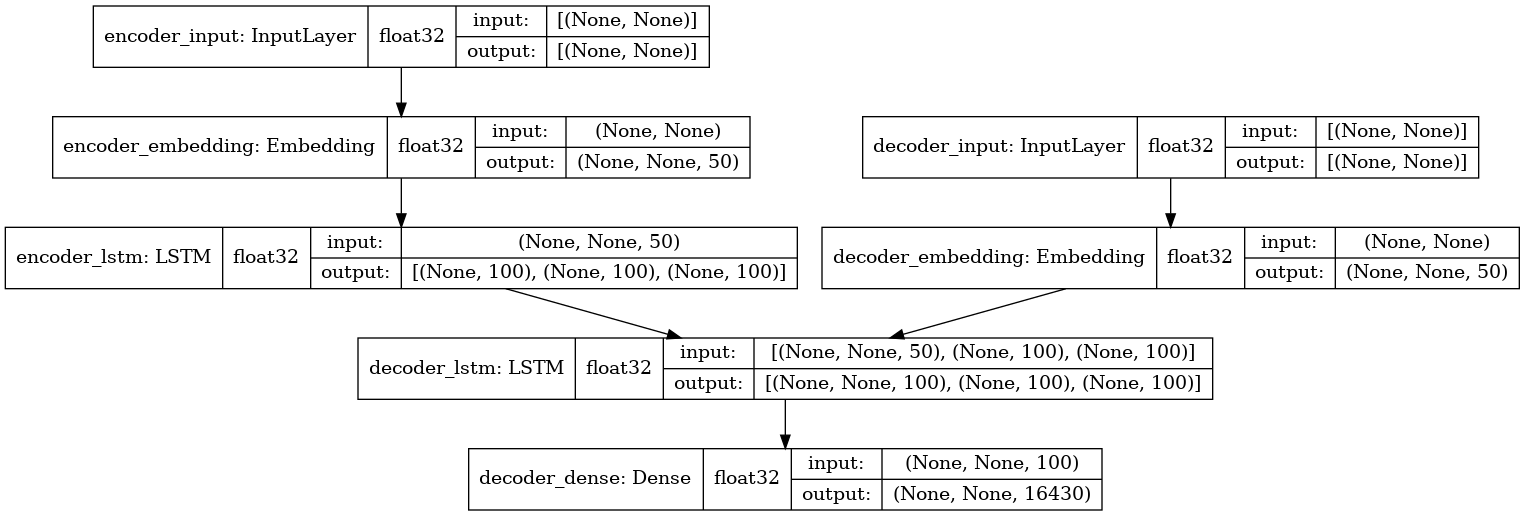

In [35]:
keras.utils.plot_model(transmodel_auto_en.model,to_file="en_auto_encoder.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [36]:
transmodel_auto_en.conf=config_auto_en
transmodel_auto_en.cut_model_encoder_decoder()

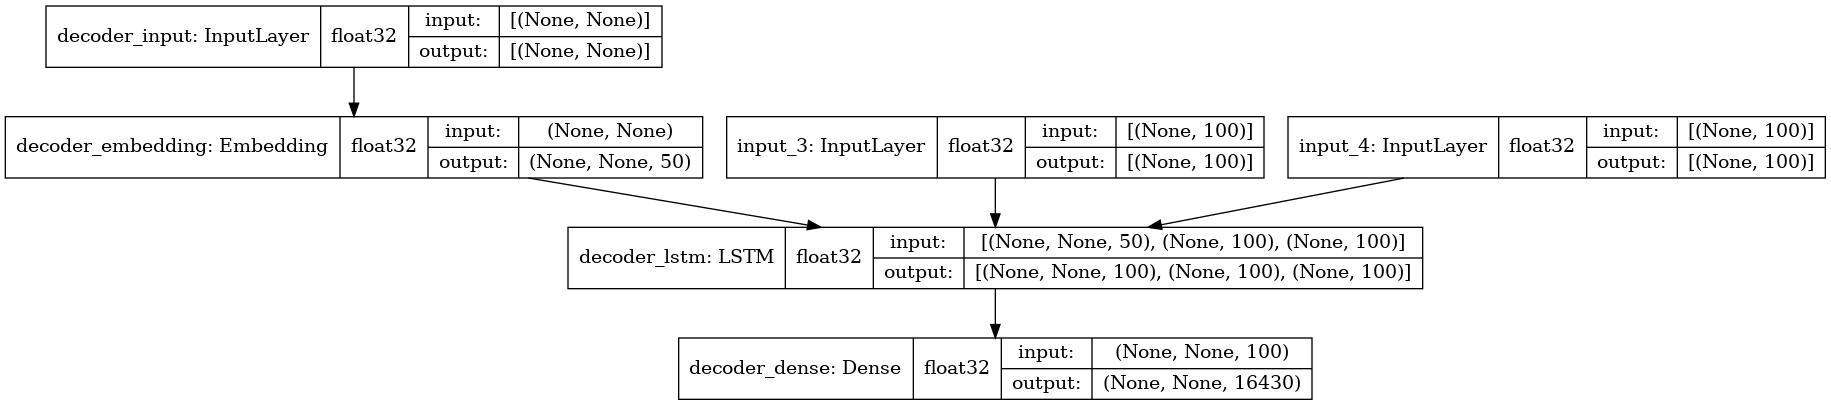

In [37]:
keras.utils.plot_model(transmodel_auto_en.decoder,to_file="en_decoder_infer.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

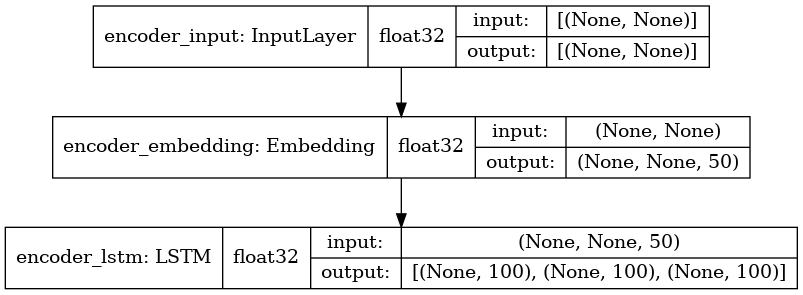

In [38]:
keras.utils.plot_model(transmodel_auto_en.encoder,to_file="en_encoder_infer.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

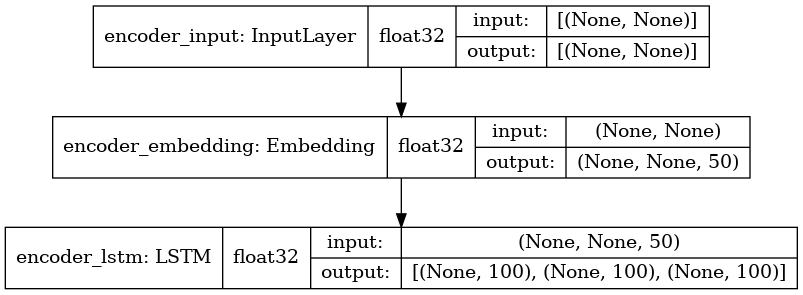

In [39]:
keras.utils.plot_model(transmodel_auto_en.encoder_hidden,to_file="en_encoder_hidden.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [40]:
print(config_auto_en)

Configuration is :

 Vocab size source =16430
 Max length source =8
 Vocab size target =16430
 Max length target= 10
 embedding dim =50
 Nb classe= 3


In [41]:
all_text_auto_encoder=[]
test_sequences_en=pre_en_en.encode_text_for_model(pre_en_en.sentences_test,with_vect=False,source=True)
#pre_en_en.tokenizer_target.word_index["<endtoken>"]
#print(states_value.shape)
print(test_sequences_en[0].shape)

(8,)


In [42]:
trans2=TranslateModel()
trans2.model=transmodel_auto_en.model
trans2.encoder=transmodel_auto_en.encoder
trans2.decoder=transmodel_auto_en.decoder
trans2.encoder_hidden=transmodel_auto_en.encoder_hidden

In [43]:
trans2.max_length_target=pre_en_en.max_length_target
transmodel_auto_en.max_length_target=pre_en_en.max_length_target

In [44]:
print(trans2.max_length_target)

10


# <span id="">Evaluation du bleu score du model auto encodeur</span>

Ici nous allons eevaluer la capacite du modele a faire de la traduction identite<br>
<a href="#top">Back to top</a>


In [45]:

# if ACTION["TRAIN_EN_AUTO_ENCODER"]==True and ACTION["PREDICT_EN_AUTO_ENCODER"]:
#     start_time=time.process_time()
#     alls_auto_encoder_preds=trans2.infer_seq2seq2(test_sequences_en,pre_en_en.tokenizer_target)
#     end_time=time.process_time()

#     first_inference_time=end_time-start_time
#     print("Pour ->",len(test_sequences_en),"l'inference a duree ",first_inference_time,"secondes")
#     print("alls_auto_encoder")

#     print(alls_auto_encoder_preds[50])
#     print(pre_en_en.sentences_test[50])

#     alls_en_auto_trad=[" ".join((re.sub("<endtoken>","",elt)).split()) for elt in alls_auto_encoder_preds]
#     print(alls_en_auto_trad[50])

#     #trans2.evaluate_model(pre_en_en.sentences_test,alls_en_auto_trad)
#     all_actuals_predicted=zip(pre_en_en.sentences_test,alls_en_auto_trad)
#     pre_en_en.save_object(all_actuals_predicted,"all_auto_en_traduction.bin")
#     all_text_auto_encoder=alls_en_auto_trad
# else:
#     try:
#         with open("../input/seq2seq-tutorial/en_en_auto_encoder_traductions.txt") as f:
#             data=f.read()
#             data=data.split("\n")
#             all_text_auto_encoder=[]
#             for elt in data:
#                 try:
#                     elt=elt.split("\t")
#                     all_text_auto_encoder.append(elt[1])
#                 except:
#                     pass
#             print(len(all_text_auto_encoder))
#             print(len(pre_en_en.sentences_test))
#     except:
#         pass

# with open("en_en_auto_encoder_traductions.txt","w") as f:
#     list_temp=[]
#     for i,elt in enumerate(all_text_auto_encoder):
#         list_temp.append(pre_en_en.sentences_test[i]+"\t "+elt)
#     f.write("\n".join(list_temp))
#     del list_temp

# transmodel_auto_en.evaluate_model(all_text_auto_encoder,pre_en_en.sentences_test)

# Quelques traductions obtenu par le modele auto encodeur

In [46]:
import random
list_to_display=[]
for elt in range(15):
    list_to_display.append(random.randint(0,len(pre_en_en.sentences_test)))
print(list_to_display)

[6223, 8097, 7086, 8406, 4268, 5774, 8011, 6353, 8352, 9285, 6271, 1662, 11053, 4019, 4652]


In [47]:
lengths_test=[]
for elt in pre_en_en.sentences_test:
    lengths_test.append(len(elt.split()))

print(max(lengths_test))

8


In [48]:
lengthst={}
for elt in lengths_test:
    lengthst[str(elt)]=lengths.get(str(elt),0)+1

In [49]:
print(lengthst)

{'7': 23625, '8': 28338, '6': 20784, '5': 17443, '4': 6491, '3': 6079, '2': 5077, '1': 3877}


In [50]:
# print("\n\n")
# for i in list_to_display:
#     print("Source: ",pre_en_en.sentences_test[i]+"\n")
#     print("Modele:",all_text_auto_encoder[i])
#     print("\n<---------------->\n")

In [51]:
print(config_auto_en.max_length_target)

10


In [52]:
en_encoder=TranslateModel()

#initialisation du modele qui calculera les sorties des phrases anglaises
en_encoder.model=transmodel_auto_en.encoder_hidden

In [53]:
#keras.utils.plot_model(en_encoder.model,to_file="en_encoder-hidden-final.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

# [Recupera des poids de l'arhitecture auto encoder de base](http://)

In [54]:
from keras.utils import plot_model
transmodel_auto_en.tokenizer_source=pre_en_en.tokenizer_target

print(len(pre_en_en.tokenizer_source.word_index))
#tf.keras.utils.plot_model(
#    transmodel_auto_en2.model, to_file='model1.png', show_shapes=True, show_dtype=True,
#    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
#)
embedding=transmodel_auto_en.save_embedding_layers()
pre_en_en.save_object(embedding,"mini_en_embedding.pkl")
pre_en_en.embedding_target=embedding
pre_en_en.embedding=embedding

16429


# Creation des sentences embeddings du francais et de l'anglais

In [55]:
pre_fr_encoder1=PrepoFrenchEncoder()
pre_fr_encoder1.load_data(nrows=NROWS,max_length=MAX_LENGTH_SENTENCE)

sentences_en_train=pre_en_en.encode_text_for_model(pre_en_en.en_aligned,source=True,with_vect=False)
if ACTION["CREATE_FR_ENCODING"]==True:
    print("fr encoding creating...")
    with open("fr_encoding.txt","w") as f:
        temps=[]
        dict_fr={}
        for i in range(0,len(pre_en_en.en_aligned),200):
            sentences=pre_fr_encoder1.fr_aligned[i:i+200]
            if ACTION["INTERNAL_REPRESENTATION"]==True:
                new_predict=en_encoder.model.predict(sentences_en_train[i:i+200])
            else:
                new_predict= pre_en_en.encode_text_for_model(pre_en_en.en_aligned[i:i+200],source=True,with_vect=True)
            
            for j,elt in enumerate(sentences):
                temps.append(elt+"\t"+" ".join([str(elt) for elt in new_predict[j]]))
                dict_fr[elt]=new_predict[j]
        f.write("\n".join(temps))
        
else:
    dict_fr=pre_en_en.load_object("../input/seq2seq-tutorial/fr_sentences_encoding.bin")

pre_en_en.save_object(dict_fr,"fr_sentences_encoding.bin")

fr encoding creating...


In [56]:
dict_fr["ce serait absurde ."]

array([-9.9858081e-01,  1.0592171e-02,  9.0872729e-04,  4.4376782e-01,
        5.6478468e-04, -3.7034595e-01,  2.2093173e-02, -2.7446973e-01,
       -6.2747854e-01, -4.5496356e-03, -9.4420153e-01, -5.6106780e-02,
        6.2747309e-03,  9.8897913e-04, -1.2402959e-01,  3.7146449e-01,
       -6.8868138e-02,  9.1738480e-01, -1.6235403e-04, -9.6753591e-01,
       -5.9032530e-01,  8.0613881e-01,  2.7077398e-01, -1.3604100e-02,
        3.6183607e-02,  1.9595331e-01,  3.8767272e-01, -7.7521294e-01,
        1.5733538e-02,  8.0660274e-03,  3.9814785e-01,  8.5937661e-01,
        5.5453259e-01, -8.1795506e-02,  7.2810357e-04, -1.1519743e-02,
        5.4018993e-02,  4.0763947e-01, -4.6977577e-01, -9.8252583e-01,
       -8.1350328e-03,  7.4522118e-03, -2.6964825e-01, -5.1458523e-02,
       -1.7312831e-01,  3.8466132e-01,  7.9637188e-01,  5.8026230e-03,
        1.6273068e-01,  1.8638723e-01,  3.5406689e-03,  7.5018609e-01,
       -2.5636899e-01, -7.4162811e-01,  9.5138747e-01,  7.4988526e-01,
      

In [57]:
if ACTION["CREATE_EN_ENCODING"]==True:
    combine_list=list(set(pre_en_en.en_aligned+pre_en_en.sentences_source+pre_en_en.sentences_test))
    combine_list_en_train=pre_en_en.encode_text_for_model(combine_list,source=True,with_vect=False)
    print("En encoding creating...")
    with open("en_encoding.txt","w") as f:
        temps=[]
        dict_en={}
        for i in range(0,len(combine_list),200):
            sentences=combine_list[i:i+200]
            if ACTION["INTERNAL_REPRESENTATION"]==True:
                new_predict=en_encoder.model.predict(combine_list_en_train[i:i+200])
            else:
                new_predict= pre_en_en.encode_text_for_model(sentences,source=True,with_vect=True)
            for j,elt in enumerate(sentences):
                temps.append(elt+"\t"+" ".join([str(elt) for elt in new_predict[j]]))
                dict_en[elt]=new_predict[j]
        f.write("\n".join(temps))
        pre_en_en.save_object(dict_en,"en_sentences_encoding.bin")
else:
    dict_en=pre_en_en.load_object("../input/seq2seq-tutorial/en_sentences_encoding.bin")

En encoding creating...


In [58]:
print(sentences_en_train[0])

[   2  337   46   19 7486  925    1    0]


# <span id="">Decodeur supervise de l'anglais</span>

Ce decodeur est un traducteur classique, il prendra en paramettre des poid de l'anglais <br>
et en sortis donnera des texte en anglais. Sauf que ici les poids de l'anglais sont ceux de la representation universelle<br>
<a href="#top">Back to summary</a>

In [59]:
if ACTION["CREATE_EN_ENCODING"]==True:
    en_sentences_encoding=pre_en_en.load_object("en_sentences_encoding.bin")
else:
    en_sentences_encoding=pre_en_en.load_object("../input/seq2seq-tutorial/en_sentences_encoding.bin")
if ACTION["CREATE_FR_ENCODING"]==True:
    fr_sentences_encoding=pre_en_en.load_object("fr_sentences_encoding.bin")
else:
    fr_sentences_encoding=pre_en_en.load_object("../input/seq2seq-tutorial/fr_sentences_encoding.bin")

pre_en_en.save_object(fr_sentences_encoding,"fr_sentences_encoding.bin")
pre_en_en.save_object(en_sentences_encoding,"en_sentences_encoding.bin")

In [60]:
keys=list(fr_sentences_encoding.keys())
keys2=list(en_sentences_encoding.keys())
#print(fr_sentences_encoding[keys[0]])
#print(en_sentences_encoding[keys2[0]])

In [61]:
pre_en_decoder=PrepoTransOther()

#pre_en_decoder.load_data("../input/europarl-parallel-corpus-19962011/english_french.csv","English","English",100)

pre_en_decoder.load_tokenizer("./mini_en_tokenizer.bin")
pre_en_decoder.max_length_source=DECODER_INPUT_SIZE
pre_en_decoder.max_length_target=MAX_LENGTH_TARGET+2
pre_en_decoder.sentences_source=pre_en_en.sentences_source
pre_en_decoder.sentences_target=pre_en_en.sentences_target
pre_en_decoder.sentences_embedding_source=en_sentences_encoding
pre_en_decoder.embedding=embedding
pre_en_decoder.embedding_target=embedding
pre_en_decoder.model_source=en_encoder.model

pairs_en_decoder=list(zip(pre_en_en.sentences_source,pre_en_en.sentences_target))



In [62]:
pairs_en_decoder[0]

('this is important .', 'this is important .')

In [63]:
print(len(list(en_sentences_encoding.keys())))
print(list(en_sentences_encoding.keys())[0])
print(len(list(set(pairs_en_decoder))))

if "thank you , commissioner ." in list(en_sentences_encoding.keys()):
    print("hello")

86583
we need the resolve of the usa .
75214
hello


In [64]:
print(en_sentences_encoding["thank you , commissioner ."].shape)

(100,)


In [65]:
pairs_en_test=list(zip(pre_en_en.sentences_test,pre_en_en.sentences_test))

In [66]:
en_decoder=TranslateModel()

if ACTION["INTERNAL_REPRESENTATION"]==True:
    en_decoder_generator=DecoderGenerator(pairs_en_decoder,100,pre_en_decoder,with_vect=True,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
    en_val_decoder_generator=DecoderGenerator(pairs_en_test,100,pre_en_decoder,with_vect=True,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
else:
    en_decoder_generator=TextGenerator(pairs_en_decoder,100,pre_en_decoder,with_vect=True,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
    en_val_decoder_generator=TextGenerator(pairs_en_test,100,pre_en_decoder,with_vect=True,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])

config_en_decoder=Config(vocab_size=pre_en_decoder.vocab_size_source,
              max_length=pre_en_decoder.max_length_source,
              vocab_size_target=pre_en_decoder.vocab_size_target,
              max_length_target=pre_en_decoder.max_length_target,
              embedding_dim=50)
    

#en_decoder.init_supervised_decoder(config_en_decoder)
#en_decoder.init_supervised_decoder_with_attention(config_en_decoder)
#en_decoder.init_supervised_decoder_with_attention2(config_en_decoder)
if ACTION["INTERNAL_REPRESENTATION"]==True:
    print("Hello")
    #config_en_decoder.optimizer="sgd"
    DecoderGenerator.model=True
    #en_decoder.init_supervised_decoder(config_en_decoder)
    if ACTION["SEQ2SEQ"]==False:
        print("not seq to seq")
        en_decoder.init_supervised_decoder_with_auto_en(config_en_decoder,transmodel_auto_en.model)
    else:
        print("Inside seq to seq")
        en_decoder.init_decoder_seq2seq(config_en_decoder)

    #en_decoder.init_supervised_decoder_with_dense(config_en_decoder)
    #en_decoder.model.optimizer.lr.assign(0.12)
else:
    en_decoder.init_supervised_decoder_with_attention(config_en_decoder)
    
en_decoder.model.summary()
    #en_decoder.model.optimizer.lr.assign(0.3)
if ACTION["TRAIN_EN_DECODER"]==True:
    print("ok")
    print(en_decoder.model.optimizer.lr)
    DecoderGenerator.model=False
    DecoderGenerator.sentences=True
    checkpoint_en_decoder=ModelCheckpoint("en_decoder_supervised.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")
    #tf.keras.utils.plot_model(en_decoder.model, to_file='en_decoder-true-model.png', show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)
    
    #en_decoder.model=keras.models.load_model("../input/k/apachefranklin/seq2seq-tutorial/en_decoder.h5")
    
    begin_time=time.process_time()
    history_en_decoder=en_decoder.model.fit(en_decoder_generator,validation_data=en_val_decoder_generator,epochs=NB_DECODER_EPOCHS,initial_epoch=0,callbacks=[checkpoint_en_decoder],verbose=VERBOSE)
    end_time=time.process_time()
    
    history_en_decoder.history["duration_training"]=end_time-begin_time
    
    pre_en_decoder.save_object(history_en_decoder.history,"en_decoder_history.bin")
    
    print(history_en_decoder.history)
    en_decoder.model.save_weights("en-decoder-weigths.w")
else:
    en_decoder.model.load_weights("../input/seq2seq-tutorial/en-decoder-weigths.w")
    en_decoder.model.save_weights("en-decoder-weigths.w")
    history_en_decoder=pre_en_decoder.load_object("../input/seq2seq-tutorial/en_decoder_history.bin")
    pre_en_decoder.save_object(history_en_decoder,"en_decoder_history.bin")
    print(history_en_decoder)

en_decoder.model.summary()


Inside generator source maxlength=  8
Inside generator target maxlength= 10
Inside generator source maxlength=  8
Inside generator target maxlength= 10
Hello
Inside seq to seq
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 50)     821500      decoder_input[0][0]              
__________________________________________________________________________________________________
encoder_lstm (L

In [67]:
#keras.utils.plot_model(en_decoder.model,to_file="en_decoder_supervised.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [68]:
print(en_decoder_generator.__getitem__(0)[1][0].shape)
print(DECODER_INPUT_SIZE)
print(config_en_decoder)
print(pre_en_decoder.max_length_source)
print(pre_en_decoder.max_length_target)
print(en_decoder_generator.__getitem__(0)[0][0].shape)

(10,)
8
Configuration is :

 Vocab size source =16430
 Max length source =8
 Vocab size target =16430
 Max length target= 10
 embedding dim =50
 Nb classe= 3
8
10
(100, 1, 100)


# Evaluation du decoder supervise de l'anglais

In [69]:
en_decoder.conf=config_en_decoder
en_decoder.cut_model_encoder_decoder()

In [70]:
#keras.utils.plot_model(en_decoder.encoder,to_file="en_decoder_encoder-supervised.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [71]:
#keras.utils.plot_model(en_decoder.decoder,to_file="en_decoder_-decoder-supervised.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [72]:
en_decoder.max_length_target=pre_en_en.max_length_target

In [73]:
print("Avaluation du decoder supervise de l'anglais\n")
pre_en_decoder.sentences_test=pre_en_en.sentences_test
pre_en_decoder.sentences_test=pre_en_en.sentences_test
all_en_text_decoder=[]

all_en_text_decoder=evaluate_decoder_traduction(en_encoder,en_decoder,pre_en_decoder,"en",ACTION["EVALUATE_EN_DECODER"])


Avaluation du decoder supervise de l'anglais

inside decdoder traduction evaluation , 11369
BLEU-1: 0.635665
BLEU-2: 0.505210
BLEU-3: 0.463760
BLEU-4: 0.362783


In [74]:
print(len(pre_en_decoder.sentences_test))

11369


In [75]:
all_en_text_decoder2=[" ".join((re.sub("<endtoken>","",elt)).split()) for elt in all_en_text_decoder]
print(all_en_text_decoder2[0])
print(all_en_text_decoder[0])

en_decoder.evaluate_model(pre_en_decoder.sentences_test,all_en_text_decoder2)

the budget should be adjusted accordingly .
the budget should be adjusted accordingly .
BLEU-1: 0.635665
BLEU-2: 0.505210
BLEU-3: 0.463760
BLEU-4: 0.362783


In [76]:
print("Quelques phrases du decodeur supervise de l'anglais")
for i in list_to_display:
    print("Source: ",pre_en_en.sentences_test[i]+"\n")
    print("Modele:",all_en_text_decoder[i])
    print("\n<---------------->\n")

Quelques phrases du decodeur supervise de l'anglais
Source:  finally , development .

Modele: finally , development .

<---------------->

Source:  i will now turn to zimbabwe .

Modele: i will now turn to nothing thursday .

<---------------->

Source:  that was my comment .

Modele: that was my comment .

<---------------->

Source:  lifestyles cannot be changed overnight .

Modele: citizens cannot be investigated this .

<---------------->

Source:  the rules only mention the president .

Modele: the plan way ahead . the .

<---------------->

Source:  the second point regards the mediator .

Modele: the second point regards our family .

<---------------->

Source:  this has proven to be the case .

Modele: this has been established very the case .

<---------------->

Source:  let me now turn to the amendments .

Modele: let me now turn to the amendments .

<---------------->

Source:  there have only been nine rejections .

Modele: there have only been moved and .

<-------------

# Evaluation du decodeur supervise de l'anglais sur le jeu d'entrainement

In [77]:
# all_sentences_train_predict=[]
# if ACTION["TRAIN_EN_DECODER"]==True:
#     for i in range(0,len(pre_en_decoder.sentences_source),200):
#         sentences=pre_en_decoder.sentences_source[i:i+200]
#         if ACTION["INTERNAL_REPRESENTATION"]==True:
#             encoded=pre_en_decoder.get_sentences_representation(sentences)
#             predicts=en_decoder.predict_sequence(encoded,pre_en_decoder.tokenizer_target)
#         else:
#             encoded=pre_en_decoder.encode_text_for_model(sentences,with_vect=True)
#             predicts=en_decoder.predict_sequence(encoded,pre_en_decoder.tokenizer_target)
#         for txt in predicts["texts"]:
#             all_sentences_train_predict.append(txt)   
#     print("Evaluation du decoder supervise de l'anglais sur le jeu d'entrainement")
#     en_decoder.evaluate_model(pre_en_decoder.sentences_source,all_sentences_train_predict)

In [78]:
#encoded=pre_en_decoder.encode_text_for_model(sentences,with_vect=True)
#print(encoded.shape)

# <a href='#'>Affichage de la courbe d'entrainement et display du temps</a>

Ici nous allons display l'historique d'entrainement du decodeur supervise de la langue anglaise.
Une epoque dure 732s ici. DOnc on peu evaluer des temps d'entraiments sur plusieurs epochs

<a href="#top">Back to summary</a>

# <span id="">Ecritures de l'encodeur supervise du francais</span>

In [79]:
pre_fr_encoder=PrepoFrenchEncoder()
pre_fr_encoder.load_data(nrows=NROWS,max_length=MAX_LENGTH_SENTENCE)

#pre_fr_encoder.sentences_source=pre_en_en.sentences_target
#pre_fr_encoder.sentences_target=pre_en_en.sentences_source

fr_sentences_encoding=pre_en_en.load_object("./fr_sentences_encoding.bin")
pre_en_en.save_object(fr_sentences_encoding,"fr_sentences_encoding.bin")
pre_fr_encoder.sentences_embedding_target=fr_sentences_encoding




if ACTION["TRAIN_FR_ENCODER"]==True:
    pre_fr_encoder.create_tokenizer_source("\n")
    pre_fr_encoder.max_length_source+=2
    print("hello i am in encoder")
    #pre_fr_encoder.max_length_source=MAX_LENGTH_SOURCE
else:
    pre_fr_encoder.load_tokenizer("../input/seq2seq-tutorial/fr_mini_tokenizer.bin")

pre_fr_encoder.embedding_target=pre_fr_encoder.load_object("./mini_en_embedding.pkl")
pre_fr_encoder.tokenizer_target=pre_en_en.tokenizer_target
pre_fr_encoder.max_length_target=pre_fr_encoder.max_length_source #ENCODER_OUTPUT_SIZE


pre_fr_encoder.vocab_size_target=pre_en_en.vocab_size_target
pre_fr_encoder.save_tokenizer("fr_mini_tokenizer.bin")
print(pre_fr_encoder.sentences_test[0])
print(pre_fr_encoder.sentences_source[0])
print("Nombre de phrases unique en Francais",len(list(set(pre_fr_encoder.sentences_source))))

Source max_length is  20
hello i am in encoder
le budget devrait y pourvoir .
c ' est là que le bât blesse !
Nombre de phrases unique en Francais 63166


In [80]:
pre_fr_encoder.tokenizer_source.word_index["<starttoken>"]

11947

In [81]:
transmodel_auto_en.model.save("en_auto_encoder_attention.h5")

In [82]:
#Ici etant donne que nous devons utiliser la representation contexte anglais, nous nous devons
#donc d'avoir l'equivalent des phrases francaises en anglais
#Raison pour laquelle sentences source et sentences target sont equivalent
sentences_pairs_encoder_fr=list(zip(pre_fr_encoder.sentences_source,pre_fr_encoder.sentences_source))
sentences_pairs_encoder_fr_test=list(zip(pre_fr_encoder.sentences_test,pre_fr_encoder.sentences_test))

en_encoder=TranslateModel()
auto_en=keras.models.load_model("./en_auto_encoder_attention.h5")
en_encoder.model=transmodel_auto_en.encoder_hidden
pre_fr_encoder.model_target=en_encoder.model


#maintenant que nous avons fait le premier pretraitement, nous devons maintenant
config_fr_enc=Config(vocab_size=pre_fr_encoder.vocab_size_source,
              max_length=pre_fr_encoder.max_length_source,
              vocab_size_target=pre_fr_encoder.vocab_size_target,
              max_length_target=pre_fr_encoder.max_length_target,
              embedding_dim=embedding_size)

print("Configuration de la langue francaise")
print(config_fr_enc)

fr_encoder=TranslateModel()
if ACTION["INTERNAL_REPRESENTATION"]==True:
    print("Hello")
    fr_encoder.init_supervised_encoder(config_fr_enc)
else:
    fr_encoder.init_supervised_encoder2(config_fr_enc)
EncoderGenerator.model=True
EncoderGenerator.sentences=True
#fr_encoder.init_supervised_encoder_with_dense(config_fr_enc)
fr_encoder.model.summary()

modelcheckpoint_fr_encodeur=ModelCheckpoint("mini_fr_encodeur.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")
checkpoint_fr_encoder_mse=ModelCheckpoint("mini_fr_encoder_mse.h5",save_best_only=True,verbose=1,monitor="mse",mode="min")
checkpoint_fr_encoder_cos=ModelCheckpoint("mini_fr_encoder_cos.h5",save_best_only=True,verbose=1,monitor="cosine_similarity",mode="max")
fr_encoder_generator=EncoderGenerator(sentences_pairs_encoder_fr,100,pre_fr_encoder,shuffle=True,with_vect=False,prediction=False)
fr_encoder_val_gen=EncoderGenerator(sentences_pairs_encoder_fr_test,100,pre_fr_encoder,shuffle=False,with_vect=False,prediction=False)

Configuration de la langue francaise
Configuration is :

 Vocab size source =20487
 Max length source =22
 Vocab size target =16430
 Max length target= 22
 embedding dim =50
 Nb classe= 3
Hello
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 44)                4224      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 22, 44)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               58000     
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
Total params: 72,324
Trainable params: 72,324
Non-trainabl

In [83]:
#keras.utils.plot_model(fr_encoder.model,to_file="fr_encoder.png",show_shapes=True, show_dtype=True,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [84]:
print("bonjour")
print(pre_fr_encoder.sentences_test[0])

bonjour
le budget devrait y pourvoir .


In [85]:
if ACTION["TRAIN_FR_ENCODER"]==True:
    print("Entrainement de l'encodeur supervise du francais")
    begin_time=time.process_time()
    history_fr_encoder=fr_encoder.model.fit(fr_encoder_generator,validation_data=fr_encoder_val_gen,epochs=NB_ENCODER_EPOCHS,initial_epoch=0,callbacks=[modelcheckpoint_fr_encodeur,checkpoint_fr_encoder_mse,checkpoint_fr_encoder_cos],verbose=VERBOSE)
    end_time=time.process_time()
    history_fr_encoder.history["duration_training"]=end_time-begin_time
    
    pre_fr_encoder.save_object(history_fr_encoder.history,"fr_encoder_train_history.obj")
    history_fr_encoder=history_fr_encoder.history
else:
    model_fr=keras.models.load_model("../input/seq2seq-tutorial/mini_fr_encodeur.h5")
    model_fr.save("mini_fr_encodeur.h5")

    model_fr=keras.models.load_model("../input/seq2seq-tutorial/mini_fr_encoder_cos.h5")
    model_fr.save("mini_fr_encoder_cos.h5")

    model_fr=keras.models.load_model("../input/seq2seq-tutorial/mini_fr_encoder_mse.h5")
    model_fr.save("mini_fr_encoder_mse.h5")
    
    history_fr_encoder=pre_fr_encoder.load_object("../input/seq2seq-tutorial/fr_encoder_train_history.obj")
    pre_fr_encoder.save_object(history_fr_encoder,"fr_encoder_train_history.obj")

    fr_encoder.model=model_fr
    
print("Historique d'entraiment de l'encodeur supervisé du francais")
print(history_fr_encoder)

Entrainement de l'encodeur supervise du francais
Epoch 1/35
651/651 - 15s - loss: 0.0601 - mse: 0.0601 - cosine_similarity: 0.8456 - mae: 0.1551 - val_loss: 0.0526 - val_mse: 0.0526 - val_cosine_similarity: 0.8671 - val_mae: 0.1405

Epoch 00001: loss improved from inf to 0.06010, saving model to mini_fr_encodeur.h5

Epoch 00001: mse improved from inf to 0.06010, saving model to mini_fr_encoder_mse.h5

Epoch 00001: cosine_similarity improved from -inf to 0.84564, saving model to mini_fr_encoder_cos.h5
Epoch 2/35
651/651 - 10s - loss: 0.0531 - mse: 0.0531 - cosine_similarity: 0.8674 - mae: 0.1411 - val_loss: 0.0512 - val_mse: 0.0512 - val_cosine_similarity: 0.8718 - val_mae: 0.1383

Epoch 00002: loss improved from 0.06010 to 0.05313, saving model to mini_fr_encodeur.h5

Epoch 00002: mse improved from 0.06010 to 0.05313, saving model to mini_fr_encoder_mse.h5

Epoch 00002: cosine_similarity improved from 0.84564 to 0.86737, saving model to mini_fr_encoder_cos.h5
Epoch 3/35
651/651 - 11s -

In [86]:
kets=list(fr_sentences_encoding.keys())[0]
kets

'le budget devrait y pourvoir .'

In [87]:
if(len(pre_fr_encoder.sentences_test)==0):
    pre_fr_encoder.sentences_test=pre_fr_encoder.load_from_txt("../input/europarltestdata/ep-test.fr")
    print(pre_fr_encoder.sentences_test[11369])
    del pre_fr_encoder.sentences_test[11369]
print(len(pre_fr_encoder.sentences_test))
print(pre_fr_encoder.sentences_test[0])

11369
le budget devrait y pourvoir .


In [88]:
stats_length_fr={}
for i in range(pre_fr_encoder.max_length_source+1):
    stats_length_fr[i]=0
for elt in pre_fr_encoder.sentences_source:
    stats_length_fr[len(elt.split())]+=1
    

# Evaluation de l'encodeur supervise du francais

In [89]:
print(pre_fr_encoder.sentences_test[0])
print(len(pre_fr_encoder.sentences_test))
length_5=0
for elt in pre_fr_encoder.sentences_test:
    if len(elt.split())<=5:
        length_5+=1
print(length_5)
    

le budget devrait y pourvoir .
11369
1517


In [90]:
print(len(pre_en_en.sentences_test_target))
print(pre_en_en.sentences_test_target[0])

11369
the budget should be arranged accordingly .


In [91]:
#On va comaprer la sortie vectorielle des differents modeles
#On va faire une prediction avec l'encodeur de l'anglais que nous allons comparer 
#Avec la sortie vectorielle envoye par le modele encodeur de la lnague francaise.

#if MAX_LENGTH_SENTENCE<50:
#    pre_fr_encoder.sentences_test=pre_en_en.sentences_test
en_encoder.model=transmodel_auto_en.encoder_hidden

score_fr_encoder=evaluate_encoder(fr_encoder,pre_fr_encoder.sentences_test,pre_fr_encoder,en_encoder,pre_en_en.sentences_test,pre_en_en)

Comme evaluation des encodeurs  

    mean squared error =  0.04497372
 Cosinus de similarite =  0.8883773967268516


# <span id="">Ecriture du decodeur supervise du francais</span>

ici au lieu d'utliser les embeddings classiques, nous allons nous servis du 
modele supervise du francais pour faire nos representations textuelles.
Donc ceci consistera faire une transformation en vecteur en utilisant le meme tokenizer creer 
plus haut, ensuite faire une predictions. Le resultat de la prediction est envoye a notre reseau de neurones.

Ceci inclu changer le generateur et l'envoyer plutot un modele au lieu d'une classe de prepocessing

<a href="#top">Back to summary</a>

In [92]:
fr_sentences_encoding=create_sentences_embedding(pre_fr_encoder,pre_fr_encoder.fr_aligned,fr_encoder,pre_en_en.en_aligned,pre_en_en,en_encoder,txt_name="fr_sentences_embeddings.txt",true_encoding=False,internal_representation=ACTION["INTERNAL_REPRESENTATION"])

In [93]:
keys_new_dict=list(fr_sentences_encoding.keys())
keys_old_dict=list(dict_fr.keys())

print(keys_old_dict[0])
print(keys_new_dict[0])

print(len(keys_old_dict))
print(len(keys_new_dict))

print(fr_sentences_encoding[keys_old_dict[1]])
print(dict_fr[keys_old_dict[1]])

le budget devrait y pourvoir .
le budget devrait y pourvoir .
74385
74385
[-9.62257683e-01  8.14727880e-03 -1.77177216e-03  5.75615108e-01
  1.98740760e-04 -3.42429012e-01 -3.99675742e-02 -2.32370257e-01
 -6.99112058e-01 -2.08710576e-03 -9.47175503e-01 -2.51760967e-02
  1.93331146e-03  7.68236758e-04 -2.28425205e-01  8.09624195e-01
 -1.73329175e-01 -2.27203757e-01 -1.90391584e-04 -9.79923487e-01
 -4.19871479e-01 -7.76804844e-03  7.13448465e-01 -3.11115151e-03
  2.77498886e-02  1.03466414e-01  9.75221574e-01 -9.14995193e-01
  1.52292568e-03 -1.41575630e-03  9.41739202e-01  9.39030647e-01
  6.26143754e-01 -1.95527077e-01 -6.43216044e-05 -5.08986972e-03
  2.36849532e-01  4.75781560e-02 -7.14613676e-01 -9.93042111e-01
  4.96062217e-04 -5.43592870e-03 -3.60236377e-01 -4.35601175e-02
 -1.18256636e-01  4.88535278e-02  9.32289243e-01  2.44808616e-03
 -7.40327477e-01  3.62391382e-01 -4.62402543e-03  4.47624743e-01
  1.70206845e-01 -9.86025155e-01  9.20346856e-01  8.38289976e-01
 -1.31895229e-01

In [94]:
pre_fr_decoder=PrepoTransOther()
#pre_fr_decoder.load_data("../input/europarl-parallel-corpus-19962011/english_french.csv","French","French",nrows=100)
pre_fr_decoder.sentences_source=pre_fr_encoder.sentences_source
pre_fr_decoder.sentences_target=pre_fr_encoder.sentences_source
pre_fr_decoder.sentences_test=pre_fr_encoder.sentences_test

pre_fr_decoder.sentences_embedding_source=fr_sentences_encoding



pre_fr_decoder.load_tokenizer("./fr_mini_tokenizer.bin")

pre_fr_decoder.tokenizer_target=pre_fr_encoder.tokenizer_source

pre_fr_decoder.max_length_target=pre_fr_encoder.max_length_source
#pre_fr_decoder.model_source=fr_encoder.model
pre_fr_decoder.max_length_source=pre_fr_encoder.max_length_source

pairs_fr_decoder=list(zip(pre_fr_decoder.sentences_source,pre_fr_decoder.sentences_source))
pairs_fr_test=list(zip(pre_fr_decoder.sentences_test,pre_fr_decoder.sentences_test))

#Maintenant que nous avons load les donnees, nous devons maintenant creer 
#le generateur de l'anglais en francais

fr_decoder_generator=DecoderGenerator(pairs_fr_decoder,100,pre_fr_decoder,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
fr_decoder_val_generator=DecoderGenerator(pairs_fr_decoder,100,pre_fr_decoder,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
DecoderGenerator.sentences=True
DecoderGenerator.model=False


config_fr_dec=Config(vocab_size=pre_fr_decoder.vocab_size_source,
              max_length=pre_fr_decoder.max_length_source,
              vocab_size_target=pre_fr_decoder.vocab_size_source,
              max_length_target=pre_fr_decoder.max_length_target,
              embedding_dim=embedding_size)

fr_decoder=TranslateModel()

if ACTION["INTERNAL_REPRESENTATION"]==True:
    print("hello internal")
    
    #fr_decoder..init_supervised_decoder_with_dense(config_fr_dec)
    if ACTION["SEQ2SEQ"]==False:
        print("not seq to seq")
        fr_decoder.init_supervised_decoder_with_attention2(config_fr_dec) 
    else:
        print("Inside seq to seq")
        fr_decoder.init_decoder_seq2seq(config_fr_dec)
else:
    fr_decoder.init_supervised_decoder_with_attention(config_fr_dec)
#fr_decoder.init_supervised_decoder_with_auto_en(config_fr_dec,transmodel_auto_en.model)

fr_decoder.model.summary()
checkpoint_fr_decoder=ModelCheckpoint("fr_decoder-supervised.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")


Inside generator source maxlength=  22
Inside generator target maxlength= 22
Inside generator source maxlength=  22
Inside generator target maxlength= 22
hello internal
Inside seq to seq
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 50)     1024350     decoder_input[0][0]              
__________________________________________________________________________________________________
enc

In [95]:
ht=fr_decoder_generator.__getitem__(0)
print(ht[0][0].shape)
print(ht[1].shape)
print(ht[1][0])

(100, 1, 100)
(100, 22)
[7.7000e+01 1.4970e+03 7.0000e+00 2.2750e+03 1.1200e+02 1.8000e+03
 3.5000e+01 2.2000e+01 3.2800e+02 5.4600e+03 1.0000e+00 1.1948e+04
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]


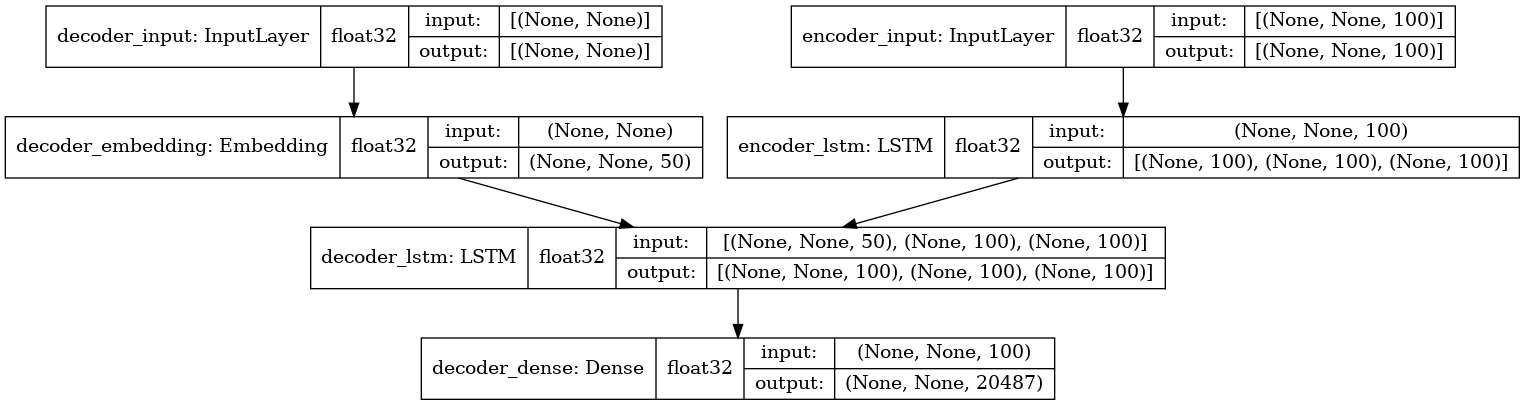

In [96]:
tf.keras.utils.plot_model(
    fr_decoder.model, to_file='fr_decoder-supervised.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [97]:
if ACTION["TRAIN_FR_DECODER"]==True:
    begin_time=time.process_time()
    history_fr_decoder=fr_decoder.model.fit(fr_decoder_generator,validation_data=fr_decoder_val_generator,epochs=NB_DECODER_EPOCHS,initial_epoch=0,callbacks=[checkpoint_fr_decoder],verbose=VERBOSE)
    end_time=time.process_time()
    history_fr_decoder.history["duration_training"]=end_time-begin_time
    pre_fr_decoder.save_object(history_fr_decoder.history,"fr_decoder_train_history.obj")
    history_fr_decoder=history_fr_decoder.history
    
    fr_decoder.model.save_weights("fr-decoder-weigths.w")
    
else:
    fr_decoder.model.load_weights("../input/seq2seq-tutorial/fr-decoder-weigths.w")
    fr_decoder.model.save_weights("fr-decoder-weigths.w")
    
    history_fr_decoder=pre_fr_decoder.load_object("../input/seq2seq-tutorial/fr_decoder_train_history.obj")
    pre_fr_decoder.save_object(history_fr_decoder,"fr_decoder_train_history.obj")

fr_decoder.conf=config_fr_dec
fr_decoder.cut_model_encoder_decoder()
fr_decoder.max_length_target=pre_fr_decoder.max_length_target

Epoch 1/35
651/651 - 93s - loss: 2.4364 - sparse_categorical_accuracy: 0.1673 - val_loss: 2.1075 - val_sparse_categorical_accuracy: 0.2503

Epoch 00001: loss improved from inf to 2.43644, saving model to fr_decoder-supervised.h5
Epoch 2/35
651/651 - 87s - loss: 1.9799 - sparse_categorical_accuracy: 0.2912 - val_loss: 1.8372 - val_sparse_categorical_accuracy: 0.3255

Epoch 00002: loss improved from 2.43644 to 1.97988, saving model to fr_decoder-supervised.h5
Epoch 3/35
651/651 - 87s - loss: 1.7656 - sparse_categorical_accuracy: 0.3450 - val_loss: 1.6719 - val_sparse_categorical_accuracy: 0.3647

Epoch 00003: loss improved from 1.97988 to 1.76559, saving model to fr_decoder-supervised.h5
Epoch 4/35
651/651 - 86s - loss: 1.6321 - sparse_categorical_accuracy: 0.3769 - val_loss: 1.5632 - val_sparse_categorical_accuracy: 0.3892

Epoch 00004: loss improved from 1.76559 to 1.63206, saving model to fr_decoder-supervised.h5
Epoch 5/35
651/651 - 86s - loss: 1.5391 - sparse_categorical_accuracy: 0

In [98]:
print("Historique d'entraiment du decodeur francais \n \n")
print(history_fr_decoder)

Historique d'entraiment du decodeur francais 
 

{'loss': [2.43644380569458, 1.9798756837844849, 1.765592098236084, 1.6320607662200928, 1.5390644073486328, 1.4680428504943848, 1.4093831777572632, 1.3604048490524292, 1.3185737133026123, 1.2823631763458252, 1.2504860162734985, 1.22166109085083, 1.1951674222946167, 1.1710996627807617, 1.1484463214874268, 1.1278249025344849, 1.1084293127059937, 1.0901360511779785, 1.0728774070739746, 1.056803584098816, 1.0414502620697021, 1.0268434286117554, 1.013100504875183, 1.000045895576477, 0.9875309467315674, 0.9755676984786987, 0.964472770690918, 0.9537906050682068, 0.9433414936065674, 0.9334501028060913, 0.9239895939826965, 0.9148172736167908, 0.9058704972267151, 0.8972335457801819, 0.8891792297363281], 'sparse_categorical_accuracy': [0.16732650995254517, 0.29121750593185425, 0.3449966609477997, 0.376919686794281, 0.3960181772708893, 0.41073107719421387, 0.42326587438583374, 0.4335476756095886, 0.4423676133155823, 0.44895732402801514, 0.45518565177

# Evaluation du decodeur supervisé du francais

Nous allons evalues les traductions obtenu par le decodeur supervise du francais, cet a dire dans un premier temps sa capacite a encoder recuperer les phrases francaises 

In [99]:
pre_fr_decoder.sentences_test=pre_fr_encoder.sentences_test
pre_fr_decoder.tokenizer_source=pre_fr_encoder.tokenizer_source
fr_test_sentences=pre_fr_encoder.sentences_test

print(pre_fr_decoder.sentences_test[0])
print(len(pre_fr_decoder.sentences_test))

le budget devrait y pourvoir .
11369


In [100]:
pre_fr_encoder.tokenizer_source.word_index["<starttoken>"]

11947

In [101]:
fr_decoder.max_length_target=pre_fr_decoder.max_length_target
print(fr_decoder.max_length_target)

22


In [102]:
print("Metric bleu score, pour le decoder Francais")

all_fr_decoder_sentences=[]

begin_time=time.process_time()
all_fr_decoder_sentences=evaluate_decoder_traduction(fr_encoder,fr_decoder,pre_fr_decoder,"fr",ACTION["EVALUATE_FR_DECODER"])
end_time=time.process_time()
print("La phase d'inference a duree ",end_time-begin_time)


Metric bleu score, pour le decoder Francais
inside decdoder traduction evaluation , 11369
BLEU-1: 0.255878
BLEU-2: 0.115764
BLEU-3: 0.089728
BLEU-4: 0.043736
La phase d'inference a duree  4747.367784887001


In [103]:
print("Quelques phrases du decodeur supervise du francais")
for i in list_to_display:
    print("Source: ",pre_fr_decoder.sentences_test[i]+"\n")
    print("Modele:",all_fr_decoder_sentences[i])
    print("\n<---------------->\n")

Quelques phrases du decodeur supervise du francais
Source:  finalement , le développement .

Modele: la commission a fait la parole .

<---------------->

Source:  j ’ en viens maintenant au zimbabwe .

Modele: je vous demande de la sorte de cette proposition .

<---------------->

Source:  voici pour ma remarque .

Modele: la commission a fait la réponse .

<---------------->

Source:  un mode de vie ne change pas du jour au lendemain .

Modele: les deux parties ont été tuées à ce niveau .

<---------------->

Source:  le règlement ne fait état que du rôle du président .

Modele: la situation est donc très grave .

<---------------->

Source:  mon second point porte sur le travail de médiation .

Modele: il s ' agit d ' une question de sécurité routière .

<---------------->

Source:  nos craintes se sont révélées justifiées .

Modele: les pays en ont été fait de la vie privée .

<---------------->

Source:  j ' en viens maintenant aux amendements .

Modele: je me suis abstenue , je l

# <a href="#">Evaluation de la traduction francais anglais</a>

Ici nous allons evaluer la traduction entre le francais et l'anglais
et vice versa. Pour traduit d'une langue vers une autre. Nous devons faire un  passer le texte source dans l'encodeur source ensuite. Recuperer la sortie et l'envoyer dans le decodeur de la langue source.

In [104]:
fr_test_sentences=pre_fr_encoder.sentences_test
en_test_sentences=pre_en_en.sentences_test

begin_time=time.process_time()
all_en_to_fr_texts=evaluate_two_traduction(en_encoder,pre_en_en,en_test_sentences,fr_decoder,pre_fr_decoder,fr_test_sentences,"en","fr",ACTION["EVALUATE_EN_FR"])
end_time=time.process_time()

print("Le temps d'evaluation entre les deux langues a pris ",end_time-begin_time)

Le temps d'evaluation entre les deux langues a pris  4625.198450717999


In [105]:
print("Bleu score de la traduction Anglais Francais")
all_en_to_fr_texts=[" ".join((re.sub("<endtoken>","",elt)).split()) for elt in all_en_to_fr_texts]
fr_decoder.evaluate_model(pre_fr_decoder.sentences_test,all_en_to_fr_texts)

Bleu score de la traduction Anglais Francais
BLEU-1: 0.301934
BLEU-2: 0.154001
BLEU-3: 0.121285
BLEU-4: 0.062898


In [106]:
print("Bleu score de la traduction Francais Anglais")


begin_time=time.process_time()
all_fr_to_en_texts=evaluate_two_traduction(fr_encoder,pre_fr_encoder,fr_test_sentences,en_decoder,pre_en_decoder,en_test_sentences,"fr","en",ACTION["EVALUATE_FR_EN"])
end_time=time.process_time()

print("Le temps d'evaluation entre les deux langues a pris ",end_time-begin_time)

print("\n------\n")


Bleu score de la traduction Francais Anglais
Le temps d'evaluation entre les deux langues a pris  3388.09736186

------



In [107]:
all_fr_to_en_texts2=[" ".join((re.sub("<endtoken>","",elt)).split()) for elt in all_fr_to_en_texts]
en_decoder.evaluate_model(pre_en_en.sentences_test,all_fr_to_en_texts2)

BLEU-1: 0.285856
BLEU-2: 0.104496
BLEU-3: 0.066095
BLEU-4: 0.026327


# Traduction Anglais Francais visualisation

In [108]:
print("Quelques traductions Anglais Francais")
for i in list_to_display:
    print("Original:",pre_en_en.sentences_test[i]+"\n")
    print("Source:  ",pre_fr_decoder.sentences_test[i]+"\n")
    print("Modele:  ",all_en_to_fr_texts[i])
    print("\n<---------------->\n")

Quelques traductions Anglais Francais
Original: finally , development .

Source:   finalement , le développement .

Modele:   enfin , le terrorisme .

<---------------->

Original: i will now turn to zimbabwe .

Source:   j ’ en viens maintenant au zimbabwe .

Modele:   je vais donc le faire .

<---------------->

Original: that was my comment .

Source:   voici pour ma remarque .

Modele:   voilà ma première proposition .

<---------------->

Original: lifestyles cannot be changed overnight .

Source:   un mode de vie ne change pas du jour au lendemain .

Modele:   les citoyens ne peuvent pas être efficaces .

<---------------->

Original: the rules only mention the president .

Source:   le règlement ne fait état que du rôle du président .

Modele:   la commission a été très brièvement .

<---------------->

Original: the second point regards the mediator .

Source:   mon second point porte sur le travail de médiation .

Modele:   la deuxième question est la question de la défense .


# Traduction Francais Anglais Visualisation


In [109]:
print("Quelques traductions Francais Anglais")
for i in list_to_display:
    print("Original:",pre_fr_decoder.sentences_test[i]+"\n")
    print("Source:  ",pre_en_decoder.sentences_test[i]+"\n")
    print("Modele:  ",all_fr_to_en_texts2[i])
    print("\n<---------------->\n")

Quelques traductions Francais Anglais
Original: finalement , le développement .

Source:   finally , development .

Modele:   thirdly , the lisbon .

<---------------->

Original: j ’ en viens maintenant au zimbabwe .

Source:   i will now turn to zimbabwe .

Modele:   i have mentioned time to japan .

<---------------->

Original: voici pour ma remarque .

Source:   that was my comment .

Modele:   you is real firm on .

<---------------->

Original: un mode de vie ne change pas du jour au lendemain .

Source:   lifestyles cannot be changed overnight .

Modele:   additional prices have been contradictory expectations .

<---------------->

Original: le règlement ne fait état que du rôle du président .

Source:   the rules only mention the president .

Modele:   the europe has been on secondary .

<---------------->

Original: mon second point porte sur le travail de médiation .

Source:   the second point regards the mediator .

Modele:   my name needs further of prisoners .

<-------

# Ajoutons la langue Espagnol dans le processus.

Nous selectionnons d'abors toutes les phrases espagnol qui ont au plus  Nous commencerons d.abord par l'encodeur

In [110]:
#create of spanish encoding
pre_es_encoder=PrepoEsEncoder()
pre_es_encoder.load_data(nrows=NROWS,max_length=MAX_LENGTH_SENTENCE)


In [111]:
print(len(pre_es_encoder.sentences_source))
print(len(pre_es_encoder.sentences_test))
print("Size of train is ",len(pre_es_encoder.sentences_source))
print(pre_es_encoder.sentences_test[2122])
print(pre_en_en.sentences_test_target[2122])

65196
11369
Size of train is  65196
¿de qué se trata ?
what is involved ?


In [112]:
print(pre_es_encoder.sentences_target[4])
print(pre_es_encoder.sentences_source[4])

pero creo que lo necesitamos .
pero creo que lo necesitamos .


In [113]:
spanish_sentences_encoding={}

if ACTION["CREATE_SPANISH_ENCODING"]==True:
    for i in range(0,len(pre_es_encoder.es_aligned),100):
        predict=pre_en_en.encode_text_with_model(pre_en_en.en_aligned[i:i+100],en_encoder.model)
        _sentences=pre_es_encoder.es_aligned[i:i+100]
        i=0
        for elt in _sentences:
            spanish_sentences_encoding[elt]=predict[i]
            i=i+1
else:
    spanish_sentences_encoding=pre_es_encoder.load_object("../input/seq2seq-tutorial/spanish_sentences_encoding.bin")

pre_es_encoder.save_object(spanish_sentences_encoding,"spanish_sentences_encoding.bin")
pre_es_encoder.sentences_embedding_target=spanish_sentences_encoding



In [114]:
if ACTION["TRAIN_SPANISH_ENCODER"]==True:
    pre_es_encoder.create_tokenizer_source("\n")
    pre_es_encoder.max_length_source+=2
    #pre_es_encoder.max_length_source=MAX_LENGTH_SOURCE
else:
    pre_es_encoder.load_tokenizer("../input/seq2seq-tutorial/spanish_mini_tokenizer.bin")

pre_es_encoder.embedding_target=pre_fr_encoder.load_object("./mini_en_embedding.pkl")
pre_es_encoder.tokenizer_target=pre_en_en.tokenizer_target
pre_es_encoder.max_length_target=pre_es_encoder.max_length_source

pre_es_encoder.vocab_size_target=pre_en_en.vocab_size_target
pre_es_encoder.save_tokenizer("spanish_mini_tokenizer.bin")
print(pre_es_encoder.max_length_source)

Source max_length is  20
22


In [115]:
sentences_pairs_encoder_es=list(zip(pre_es_encoder.sentences_source,pre_es_encoder.sentences_source))
sentences_pairs_es_test=list(zip(pre_es_encoder.sentences_test,pre_es_encoder.sentences_test))

es_encoder=TranslateModel()
auto_en=keras.models.load_model("./en_auto_encoder_attention.h5")
#en_encoder.init_hidden_state_model(config_auto_en,auto_en)
pre_es_encoder.model_target=en_encoder.model


#maintenant que nous avons fait le premier pretraitement, nous devons maintenant
config_es_enc=Config(vocab_size=pre_es_encoder.vocab_size_source,
              max_length=pre_es_encoder.max_length_source,
              vocab_size_target=pre_es_encoder.vocab_size_target,
              max_length_target=pre_es_encoder.max_length_target,
              embedding_dim=embedding_size)

es_encoder=TranslateModel()
#fr_encoder.init_supervised_encoder_with_attention(config_fr_enc)
es_encoder.init_supervised_encoder(config_es_enc)
EncoderGenerator.model=True
EncoderGenerator.sentences=True
#fr_encoder.init_supervised_encoder_with_dense(config_fr_enc)
es_encoder.model.summary()

modelcheckpoint_es_encodeur=ModelCheckpoint("mini_es_encodeur.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")
checkpoint_es_encoder_mse=ModelCheckpoint("mini_es_encoder_mse.h5",save_best_only=True,verbose=1,monitor="mse",mode="min")
checkpoint_es_encoder_cos=ModelCheckpoint("mini_es_encoder_cos.h5",save_best_only=True,verbose=1,monitor="cosine_similarity",mode="max")
es_encoder_generator=EncoderGenerator(sentences_pairs_encoder_es,100,pre_es_encoder,shuffle=True,with_vect=False,prediction=False)
es_encoder_val_generator=EncoderGenerator(sentences_pairs_es_test,100,pre_es_encoder,shuffle=True,with_vect=False,prediction=False)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 44)                4224      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 22, 44)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               58000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
Total params: 72,324
Trainable params: 72,324
Non-trainable params: 0
_________________________________________________________________
Inside generator source maxlength=  22
Inside generator target maxlength= 22
Inside generator source maxlength=  22

In [116]:
if ACTION["TRAIN_SPANISH_ENCODER"]==True:
    print("Entrainement de l'encodeur supervise de l'espagnol")
    begin_time=time.process_time()
    history_es_encoder=es_encoder.model.fit(es_encoder_generator,validation_data=es_encoder_val_generator,epochs=NB_ENCODER_EPOCHS,initial_epoch=0,callbacks=[modelcheckpoint_es_encodeur,checkpoint_es_encoder_mse,checkpoint_es_encoder_cos],verbose=VERBOSE)
    end_time=time.process_time()
    
    history_es_encoder.history["duration_training"]=end_time-begin_time
    
    pre_es_encoder.save_object(history_es_encoder.history,"es_encoder_train_history.obj")
    history_es_encoder=history_es_encoder.history
else:
    model_es=keras.models.load_model("../input/seq2seq-tutorial/mini_es_encodeur.h5")
    model_es.save("mini_es_encodeur.h5")

    model_es=keras.models.load_model("../input/seq2seq-tutorial/mini_es_encoder_cos.h5")
    model_es.save("mini_es_encoder_cos.h5")

    model_es=keras.models.load_model("../input/seq2seq-tutorial/mini_es_encoder_mse.h5")
    model_es.save("mini_es_encoder_mse.h5")
    
    history_es_encoder=pre_fr_encoder.load_object("../input/seq2seq-tutorial/es_encoder_train_history.obj")
    pre_es_encoder.save_object(history_es_encoder,"es_encoder_train_history.obj")

    es_encoder.model=model_es
    


Entrainement de l'encodeur supervise de l'espagnol
Epoch 1/35
652/652 - 14s - loss: 0.0592 - mse: 0.0592 - cosine_similarity: 0.8494 - mae: 0.1530 - val_loss: 0.0534 - val_mse: 0.0534 - val_cosine_similarity: 0.8650 - val_mae: 0.1419

Epoch 00001: loss improved from inf to 0.05919, saving model to mini_es_encodeur.h5

Epoch 00001: mse improved from inf to 0.05919, saving model to mini_es_encoder_mse.h5

Epoch 00001: cosine_similarity improved from -inf to 0.84938, saving model to mini_es_encoder_cos.h5
Epoch 2/35
652/652 - 10s - loss: 0.0532 - mse: 0.0532 - cosine_similarity: 0.8671 - mae: 0.1410 - val_loss: 0.0520 - val_mse: 0.0520 - val_cosine_similarity: 0.8686 - val_mae: 0.1384

Epoch 00002: loss improved from 0.05919 to 0.05324, saving model to mini_es_encodeur.h5

Epoch 00002: mse improved from 0.05919 to 0.05324, saving model to mini_es_encoder_mse.h5

Epoch 00002: cosine_similarity improved from 0.84938 to 0.86708, saving model to mini_es_encoder_cos.h5
Epoch 3/35
652/652 - 10s

# Evaluation de l'encodeur supervisé de l'espagnol

In [117]:
print("Historique d'entraiment de l'encodeur supervisé de l'espagnol")
print(history_es_encoder)

Historique d'entraiment de l'encodeur supervisé de l'espagnol
{'loss': [0.0591876320540905, 0.053243424743413925, 0.05228303000330925, 0.05157839506864548, 0.05108175426721573, 0.05071572959423065, 0.050404466688632965, 0.05016196891665459, 0.049928661435842514, 0.04971267282962799, 0.049533918499946594, 0.04924711957573891, 0.04913356900215149, 0.048990458250045776, 0.048893023282289505, 0.048732440918684006, 0.04856965318322182, 0.04846362769603729, 0.04833798483014107, 0.04819618910551071, 0.04808230698108673, 0.04801303148269653, 0.047893308103084564, 0.047773439437150955, 0.047708574682474136, 0.0476357601583004, 0.04752188175916672, 0.04747292026877403, 0.04733537882566452, 0.04727410152554512, 0.04719766974449158, 0.04712136462330818, 0.04708884283900261, 0.04696674644947052, 0.0469411239027977], 'mse': [0.0591876320540905, 0.053243424743413925, 0.05228303000330925, 0.05157839506864548, 0.05108175426721573, 0.05071572959423065, 0.050404466688632965, 0.05016196891665459, 0.049928

In [118]:
print("Evaluation de l'encodeur espagnol")
evaluate_encoder(es_encoder,pre_es_encoder.sentences_test,pre_es_encoder,en_encoder,pre_en_decoder.sentences_test,pre_en_decoder)

Evaluation de l'encodeur espagnol
Comme evaluation des encodeurs  

    mean squared error =  0.046970688
 Cosinus de similarite =  0.8828089533054071


{'mse': 0.046970688, 'cos': 0.8828089533054071}

# Construction du decodeur de l'espagnol

In [119]:
lengths_spanish=[len(elt.split()) for elt in pre_es_encoder.sentences_source]
print(max(lengths_spanish))
print(pre_es_encoder.sentences_source[30])
print(print(pre_es_encoder.sentences_target[30]))

20
me complace que el comisario lo haya señalado .
me complace que el comisario lo haya señalado .
None


In [120]:
spanish_sentences_encoding=create_sentences_embedding(pre_es_encoder,pre_es_encoder.es_aligned,es_encoder,pre_en_en.en_aligned,pre_en_en,en_encoder,txt_name="spanish_sentences_embeddings.txt",true_encoding=False,internal_representation=ACTION["INTERNAL_REPRESENTATION"])

In [121]:
pre_es_decoder=PrepoTransOther()
#pre_es_decoder.load_data("../input/europarl-parallel-corpus-19962011/english_french.csv","French","French",nrows=100)
pre_es_decoder.sentences_source=pre_es_encoder.sentences_source
pre_es_decoder.sentences_target=pre_es_encoder.sentences_source
pre_es_decoder.sentences_test=pre_es_encoder.sentences_test

pre_es_decoder.sentences_embedding_source=spanish_sentences_encoding



pre_es_decoder.load_tokenizer("./spanish_mini_tokenizer.bin")
pre_es_decoder.tokenizer_target=pre_es_decoder.tokenizer_source
pre_es_decoder.max_length_target=pre_es_encoder.max_length_source
#pre_es_decoder.model_source=es_encoder.model
pre_es_decoder.max_length_source=pre_es_encoder.max_length_source

pairs_es_decoder=list(zip(pre_es_decoder.sentences_source,pre_es_decoder.sentences_source))
pairs_es_test=list(zip(pre_es_decoder.sentences_test,pre_es_decoder.sentences_test))

#Maintenant que nous avons load les donnees, nous devons maintenant creer 
#le generateur de l'anglais en francais

es_decoder_generator=DecoderGenerator(pairs_es_decoder,100,pre_es_decoder,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
es_decoder_val_generator=DecoderGenerator(pairs_es_test,100,pre_es_decoder,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])

DecoderGenerator.sentences=True
DecoderGenerator.model=False


config_es_dec=Config(vocab_size=pre_es_decoder.vocab_size_source,
              max_length=pre_es_decoder.max_length_source,
              vocab_size_target=pre_es_decoder.vocab_size_source,
              max_length_target=pre_es_decoder.max_length_target,
              embedding_dim=embedding_size)

es_decoder=TranslateModel()

if ACTION["INTERNAL_REPRESENTATION"]==True:
    print("hello internal")
    #en_decoder.init_supervised_decoder(config_en_decoder)
    if ACTION["SEQ2SEQ"]==False:
        print("not seq to seq")
        es_decoder.init_supervised_decoder_with_attention2(config_es_dec) 
    else:
        print("Inside seq to seq")
        es_decoder.init_decoder_seq2seq(config_es_dec)
        
    #es_decoder.init_supervised_decoder_with_dense(config_es_dec)
else:
    es_decoder.init_supervised_decoder_with_attention(config_es_dec)
#es_decoder.init_supervised_decoder_with_auto_en(config_es_dec,transmodel_auto_en.model)

es_decoder.model.summary()
checkpoint_es_decoder=ModelCheckpoint("es_decoder-supervised.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")


Inside generator source maxlength=  22
Inside generator target maxlength= 22
Inside generator source maxlength=  22
Inside generator target maxlength= 22
hello internal
Inside seq to seq
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      [(None, None, 100)]  0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 50)     1185150     decoder_input[0][0]              
__________________________________________________________________________________________________
enc

In [122]:
if ACTION["TRAIN_SPANISH_DECODER"]==True:
    begin_time=time.process_time()
    history_es_decoder=es_decoder.model.fit(es_decoder_generator,validation_data=es_decoder_val_generator,epochs=NB_DECODER_EPOCHS,initial_epoch=0,callbacks=[checkpoint_es_decoder],verbose=VERBOSE)
    end_time=time.process_time()
    
    history_es_decoder.history["duration_training"]=end_time-begin_time
    
    pre_es_decoder.save_object(history_es_decoder.history,"es_decoder_train_history.obj")
    history_es_decoder=history_es_decoder.history
    
    #separation du decodeur espagnol en modele encodeur decodeur
    es_decoder.model.save_weights("es-decoder-weigths.w")
    
else:
    es_decoder.model.load_weights("../input/seq2seq-tutorial/es-decoder-weigths.w")
    es_decoder.model.save_weights("es-decoder-weigths.w")
    history_es_decoder=pre_es_decoder.load_object("../input/seq2seq-tutorial/es_decoder_train_history.obj")
    pre_es_decoder.save_object(history_es_decoder,"es_decoder_train_history.obj")

es_decoder.conf=config_es_dec
es_decoder.cut_model_encoder_decoder()
print("Historique d'enrainement du decodeur espagnol")
print(history_es_decoder)

Epoch 1/35
652/652 - 68s - loss: 2.1867 - sparse_categorical_accuracy: 0.1738 - val_loss: 1.9380 - val_sparse_categorical_accuracy: 0.2526

Epoch 00001: loss improved from inf to 2.18668, saving model to es_decoder-supervised.h5
Epoch 2/35
652/652 - 62s - loss: 1.8316 - sparse_categorical_accuracy: 0.2830 - val_loss: 1.7457 - val_sparse_categorical_accuracy: 0.3082

Epoch 00002: loss improved from 2.18668 to 1.83162, saving model to es_decoder-supervised.h5
Epoch 3/35
652/652 - 62s - loss: 1.6597 - sparse_categorical_accuracy: 0.3242 - val_loss: 1.6235 - val_sparse_categorical_accuracy: 0.3391

Epoch 00003: loss improved from 1.83162 to 1.65967, saving model to es_decoder-supervised.h5
Epoch 4/35
652/652 - 62s - loss: 1.5397 - sparse_categorical_accuracy: 0.3524 - val_loss: 1.5420 - val_sparse_categorical_accuracy: 0.3598

Epoch 00004: loss improved from 1.65967 to 1.53966, saving model to es_decoder-supervised.h5
Epoch 5/35
652/652 - 62s - loss: 1.4498 - sparse_categorical_accuracy: 0

# Evaluation du decodeur supervise de l'espagnol



In [123]:
pre_es_decoder.sentences_test=pre_es_encoder.sentences_test
print(pre_es_decoder.sentences_test[1])
print(pre_fr_encoder.sentences_test[1])

debemos alabar sus esfuerzos .
il faut le féliciter de ses efforts .


In [124]:
es_decoder.max_length_target=pre_es_decoder.max_length_source

In [ ]:

print("Metric bleu score, pour le decoder Espagnol")
begin_time=time.process_time()
all_es_decoder_sentences=evaluate_decoder_traduction(es_encoder,es_decoder,pre_es_decoder,'es',ACTION["EVALUATE_SPANISH_DECODER"])
end_time=time.process_time()

print("L'evaluation du decodeur espagnol a pris ",end_time-begin_time)


Metric bleu score, pour le decoder Espagnol


# Quelques traductions du modeles decodeur de l'espagnol



In [ ]:
print("Quelques phrases du decodeur supervise du francais")
for i in list_to_display:
    print("Source: ",pre_es_decoder.sentences_test[i]+"\n")
    print("Modele:",all_es_decoder_sentences[i])
    print("\n<---------------->\n")

# Traduction de l'espagnol vers les langues et vice versa

In [ ]:
print(es_decoder.max_length_target)

In [ ]:
es_test_sent=pre_es_encoder.sentences_test

begin_time=time.process_time()
all_en_to_spanish_texts=evaluate_two_traduction(en_encoder,pre_en_en,pre_en_en.sentences_test,es_decoder,pre_es_decoder,es_test_sent,"en","es",ACTION["EVALUATE_EN_SPANISH"])
end_time=time.process_time()
print("L'evaluation entre l'anglais et l'espagnol a duree ",end_time-begin_time)

begin_time=time.process_time()
all_fr_to_spanish_texts=evaluate_two_traduction(fr_encoder,pre_fr_encoder,pre_fr_encoder.sentences_test,es_decoder,pre_es_decoder,es_test_sent,"fr","es",ACTION["EVALUATE_FR_SPANISH"])

print("L'evaluation entre le francais et l'espagnol a duree ",time.process_time()-begin_time)

begin_time=time.process_time()
all_spanish_to_en_texts=evaluate_two_traduction(es_encoder,pre_es_encoder,es_test_sent,en_decoder,pre_en_decoder,pre_fr_encoder.sentences_test,"es","en",ACTION["EVALUATE_SPANISH_EN"])

print("L'evaluation entre l'espagnol et l'anglais a duree ",time.process_time()-begin_time)

begin_time=time.process_time()
all_spanish_to_fr_texts=evaluate_two_traduction(es_encoder,pre_es_encoder,es_test_sent,fr_decoder,pre_fr_decoder,pre_fr_encoder.sentences_test,"es","fr",ACTION["EVALUATE_SPANISH_FR"])
print("L'evaluation entre l'espagnol et le francais a duree ",time.process_time()-begin_time)
end_time=time.process_time()

print("La traduction en")

In [ ]:
print("Bleu score de la traduction Espagnol Anglais")
es_decoder.evaluate_model(pre_en_en.sentences_test,all_spanish_to_en_texts)
print("\n-----------------\n")

print("Bleu score de la traduction Anglais Espagnol")
es_decoder.evaluate_model(pre_es_decoder.sentences_test,all_en_to_spanish_texts)
print("\n-----------------\n")

print("Bleu score de la traduction Espagnol Francais")
es_decoder.evaluate_model(pre_fr_decoder.sentences_test,all_spanish_to_fr_texts)

print("\n-----------------\n")
print("Bleu score de la traduction Francais Espagnol")
es_decoder.evaluate_model(pre_es_decoder.sentences_test,all_fr_to_spanish_texts)


print("\n-----------------\n")
print("Bleu score de la traduction Anglais Francais")

fr_decoder.evaluate_model(pre_fr_decoder.sentences_test,all_en_to_fr_texts)

print("\n-----------------\n")
print("Bleu score de la traduction Francais Anglais")
en_decoder.evaluate_model(pre_en_en.sentences_test,all_fr_to_en_texts)

# Ajout incrementale de la langue yemba

In [ ]:
pre_yemba=PrepoYemba()
pre_yemba.load_data()

In [ ]:
# Constrruction du sentences embedding de la langue yemba
print(pre_yemba.sentences_target[0])
all_yemba_sentences=list(pre_yemba.sentences_source)+list(pre_yemba.sentences_test)
all_yemba_target=list(pre_yemba.sentences_target)+list(pre_yemba.english_test)

sentences_en_yemba_train=pre_en_en.encode_text_for_model(all_yemba_target,source=True,with_vect=False)
if ACTION["CREATE_YEMBA_ENCODING"]==True:
    print("yemba  encoding creating...")
    with open("yemba_encoding.txt","w") as f:
        temps=[]
        dict_yemba={}
        for i in range(0,len(all_yemba_target),200):
            sentences=all_yemba_sentences[i:i+200]
            if ACTION["INTERNAL_REPRESENTATION"]==True:
                new_predict=en_encoder.model.predict(sentences_en_yemba_train[i:i+200])
            else:
                new_predict= pre_en_en.encode_text_for_model(all_yemba_target[i:i+200],source=True,with_vect=True)
            
            for j,elt in enumerate(sentences):
                temps.append(elt+"\t"+" ".join([str(elt) for elt in new_predict[j]]))
                dict_yemba[elt]=new_predict[j]
        f.write("\n".join(temps))
        pre_yemba.save_object(dict_yemba,"yemba_sentences_encoding.bin")
        yemba_sentences_encoding=dict_yemba
else:
    yemba_sentences_encoding=pre_en_en.load_object("../input/seq2seq-tutorial/yemba_sentences_encoding.bin")
    pre_yemba.save_object(yemba_sentences_encoding,"yemba_sentences_encoding.bin")

In [ ]:
pre_yemba.sentences_embedding_target=yemba_sentences_encoding
if ACTION["TRAIN_YEMBA_ENCODER"]==True:
    pre_yemba.create_tokenizer_source("\n")
    pre_yemba.max_length_source+=2
    print("hello i am in encoder of yemba")
    #pre_fr_encoder.max_length_source=MAX_LENGTH_SOURCE
else:
    pre_yemba.load_tokenizer("../input/seq2seq-tutorial/yemba_mini_tokenizer.bin")

pre_yemba.embedding_target=pre_yemba.load_object("./mini_en_embedding.pkl")
pre_yemba.tokenizer_target=pre_en_en.tokenizer_source
pre_yemba.max_length_target=ENCODER_OUTPUT_SIZE


pre_yemba.vocab_size_target=pre_en_en.vocab_size_target
pre_fr_encoder.save_tokenizer("yemba_mini_tokenizer.bin")
print(pre_yemba.sentences_test[0])
print(pre_yemba.sentences_source[0])

In [ ]:
#Ici etant donne que nous devons utiliser la representation contexte anglais, nous nous devons
#donc d'avoir l'equivalent des phrases francaises en anglais
#Raison pour laquelle sentences source et sentences target sont equivalent
sentences_pairs_encoder_yemba=list(zip(pre_yemba.sentences_source,pre_yemba.sentences_source))
sentences_pairs_yemba_test=list(zip(pre_yemba.sentences_test,pre_yemba.sentences_test))

pre_es_encoder.model_target=en_encoder.model

pre_yemba.model_target=en_encoder.model


#maintenant que nous avons fait le premier pretraitement, nous devons maintenant
config_yemba_enc=Config(vocab_size=pre_yemba.vocab_size_source,
              max_length=pre_yemba.max_length_source,
              vocab_size_target=pre_yemba.vocab_size_target,
              max_length_target=pre_yemba.max_length_target,
              embedding_dim=embedding_size)

print("Configuration de la langue Yemba")
print(config_yemba_enc)

yemba_encoder=TranslateModel()
if ACTION["INTERNAL_REPRESENTATION"]==True:
    print("Hello i try yemba")
    yemba_encoder.init_supervised_encoder(config_yemba_enc)
else:
    yemba_encoder.init_supervised_encoder2(config_yemba_enc)
EncoderGenerator.model=True
EncoderGenerator.sentences=True
#fr_encoder.init_supervised_encoder_with_dense(config_fr_enc)
yemba_encoder.model.summary()

modelcheckpoint_yemba_encodeur=ModelCheckpoint("mini_yemba_encodeur.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")
checkpoint_yemba_encoder_mse=ModelCheckpoint("mini_yemba_encoder_mse.h5",save_best_only=True,verbose=1,monitor="mse",mode="min")
checkpoint_yemba_encoder_cos=ModelCheckpoint("mini_yemba_encoder_cos.h5",save_best_only=True,verbose=1,monitor="cosine_similarity",mode="max")

yemba_encoder_generator=EncoderGenerator(sentences_pairs_encoder_yemba,100,pre_yemba,shuffle=True,with_vect=False,prediction=False)
yemba_encoder_val_generator=EncoderGenerator(sentences_pairs_yemba_test,100,pre_yemba,shuffle=True,with_vect=False,prediction=False)

In [ ]:
if ACTION["TRAIN_YEMBA_ENCODER"]==True:
    print("Entrainement de l'encodeur supervise du yemba")
    begin_time=time.process_time()
    history_yemba_encoder=yemba_encoder.model.fit(yemba_encoder_generator,validation_data=yemba_encoder_val_generator,epochs=NB_ENCODER_EPOCHS*2,initial_epoch=0,callbacks=[modelcheckpoint_yemba_encodeur,checkpoint_yemba_encoder_mse,checkpoint_yemba_encoder_cos],verbose=VERBOSE)
    end_time=time.process_time()
    history_yemba_encoder.history["duration_training"]=end_time-begin_time
    
    pre_yemba.save_object(history_yemba_encoder.history,"yemba_encoder_train_history.obj")
    history_yemba_encoder=history_yemba_encoder.history
else:
    model_yemba=keras.models.load_model("../input/seq2seq-tutorial/mini_yemba_encodeur.h5")
    model_yemba.save("mini_yemba_encodeur.h5")

    model_yemba=keras.models.load_model("../input/seq2seq-tutorial/mini_yemba_encoder_cos.h5")
    model_yemba.save("mini_yemba_encoder_cos.h5")

    model_yemba=keras.models.load_model("../input/seq2seq-tutorial/mini_yemba_encoder_mse.h5")
    model_yemba.save("mini_yemba_encoder_mse.h5")
    
    history_yemba_encoder=pre_fr_encoder.load_object("../input/seq2seq-tutorial/yemba_encoder_train_history.obj")
    pre_yemba.save_object(history_yemba_encoder,"yemba_encoder_train_history.obj")

    yemba_encoder.model=model_yemba
    
print("Historique d'entraiment de l'encodeur supervisé du yemba")
print(history_yemba_encoder)

In [ ]:
original_en_test=list(pre_en_en.sentences_test)
pre_en_en.sentences_test=pre_yemba.english_test

# Evaluation de l'encodeur supervise du yemba

In [ ]:
print("evaluation de l'encodeur yemba")
evaluate_encoder(yemba_encoder,pre_yemba.sentences_test,pre_yemba,en_encoder,pre_yemba.english_test,pre_en_en)
pre_en_en.sentences_test=original_en_test

# Construction du decodeur de la langue yemba

In [ ]:
pre_yemba_decoder=PrepoTransOther()
#pre_es_decoder.load_data("../input/europarl-parallel-corpus-19962011/english_french.csv","French","French",nrows=100)
pre_yemba_decoder.sentences_source=pre_yemba.sentences_source
pre_yemba_decoder.sentences_target=pre_yemba.sentences_source
pre_yemba_decoder.sentences_test=pre_yemba.sentences_test

pre_yemba_decoder.sentences_embedding_source=yemba_sentences_encoding



pre_yemba_decoder.load_tokenizer("./yemba_mini_tokenizer.bin")
pre_yemba_decoder.tokenizer_source=pre_yemba.tokenizer_source
pre_yemba_decoder.max_length_source=pre_yemba.max_length_source
pre_yemba_decoder.vocab_size_source=pre_yemba.vocab_size_source
pre_yemba_decoder.vocab_size_target=pre_yemba.vocab_size_target
pre_yemba_decoder.tokenizer_target=pre_yemba.tokenizer_source
pre_yemba_decoder.max_length_target=pre_yemba.max_length_source
#pre_es_decoder.model_source=es_encoder.model
pre_yemba_decoder.max_length_source=pre_yemba.max_length_source #DECODER_INPUT_SIZE

pairs_yemba_decoder=list(zip(pre_yemba_decoder.sentences_source,pre_yemba_decoder.sentences_source))
pairs_yemba_test=list(zip(pre_yemba.sentences_test,pre_yemba.sentences_test))

#Maintenant que nous avons load les donnees, nous devons maintenant creer 
#le generateur de l'anglais en francais

yemba_decoder_generator=DecoderGenerator(pairs_yemba_decoder,100,pre_yemba_decoder,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
yemba_decoder_val_generator=DecoderGenerator(pairs_yemba_test,100,pre_yemba_decoder,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
DecoderGenerator.sentences=True
DecoderGenerator.model=False


config_yemba_dec=Config(vocab_size=pre_yemba_decoder.vocab_size_source,
              max_length=pre_yemba_decoder.max_length_source,
              vocab_size_target=pre_yemba_decoder.vocab_size_source,
              max_length_target=pre_yemba_decoder.max_length_target,
              embedding_dim=embedding_size)

yemba_decoder=TranslateModel()

if ACTION["INTERNAL_REPRESENTATION"]==True:
    print("hello internal")
    #en_decoder.init_supervised_decoder(config_en_decoder)
    if ACTION["SEQ2SEQ"]==False:
        print("not seq to seq")
        yemba_decoder.init_supervised_decoder_with_attention2(config_yemba_dec) 
    else:
        print("Inside seq to seq")
        yemba_decoder.init_decoder_seq2seq(config_yemba_dec)
else:
    yemba_decoder.init_supervised_decoder_with_attention(config_yemba_dec)


yemba_decoder.model.summary()
checkpoint_yemba_decoder=ModelCheckpoint("yemba_decoder-supervised.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")

if ACTION["TRAIN_YEMBA_DECODER"]==True:
    
    begin_time=time.process_time()
    history_yemba_decoder=yemba_decoder.model.fit(yemba_decoder_generator,validation_data=yemba_decoder_val_generator,epochs=NB_DECODER_EPOCHS*2,initial_epoch=0,callbacks=[checkpoint_yemba_decoder],verbose=VERBOSE)
    end_time=time.process_time()
    history_yemba_decoder.history["duration_training"]=end_time-begin_time
    
    pre_yemba_decoder.save_object(history_yemba_decoder.history,"yemba_decoder_train_history.obj")
    history_yemba_decoder=history_yemba_decoder.history
    yemba_decoder.model.save_weights("yemba-decoder-weigths.w")
    #separatin du modele yemba en encodeu et decodeur pour la phase d'inference

else:
    yemba_decoder.model.load_weights("../input/seq2seq-tutorial/yemba-decoder-weigths.w")
    yemba_decoder.model.save_weights("yemba-decoder-weigths.w")
    history_yemba_decoder=pre_yemba_decoder.load_object("../input/seq2seq-tutorial/yemba_decoder_train_history.obj")
    pre_yemba_decoder.save_object(history_yemba_decoder,"yemba_decoder_train_history.obj")
    
print("Historique d'enrainement du decodeur yemba")
print(history_yemba_decoder)
yemba_decoder.conf=config_yemba_dec
yemba_decoder.cut_model_encoder_decoder()

In [ ]:
yemba_decoder.max_length_target=pre_yemba.max_length_source

# Evaluation du decoder de la langue yemba

In [ ]:
pre_yemba_decoder.sentences_test=pre_yemba.sentences_test
print(pre_yemba_decoder.sentences_test)

In [ ]:
print("Metric bleu score, pour le decoder Yemba")
all_yemba_decoder_sentences=evaluate_decoder_traduction(yemba_encoder,yemba_decoder,pre_yemba_decoder,'yemba',ACTION["EVALUATE_YEMBA_DECODER"])
#yemba_decoder.evaluate_model(pre_yemba_decoder.sentences_test,all_yemba_decoder_sentences)

print(all_yemba_decoder_sentences)

# Evaluation des diffenrentes traduction entre le yemba et les autres

In [ ]:
yb_test=pre_yemba.sentences_test

all_en_to_yemba_texts=evaluate_two_traduction(en_encoder,pre_en_en,pre_yemba.english_test,yemba_decoder,pre_yemba_decoder,pre_yemba.sentences_test,"en","yemba")

all_fr_to_yemba_texts=evaluate_two_traduction(fr_encoder,pre_fr_encoder,pre_yemba.french_test,yemba_decoder,pre_yemba_decoder,pre_yemba.sentences_test,"fr","yemba")

all_spanish_to_yemba_texts=evaluate_two_traduction(es_encoder,pre_es_encoder,pre_yemba.spanish_test,yemba_decoder,pre_yemba_decoder,yb_test,"es","yemba")

all_yemba_to_fr_texts=evaluate_two_traduction(yemba_encoder,pre_yemba,yb_test,fr_decoder,pre_fr_decoder,pre_yemba.french_test,"yemba","fr")

all_yemba_to_spanish_texts=evaluate_two_traduction(yemba_encoder,pre_yemba,yb_test,es_decoder,pre_es_decoder,pre_yemba.spanish_test,"yemba","es")

all_yemba_to_en_texts=evaluate_two_traduction(yemba_encoder,pre_yemba,yb_test,en_decoder,pre_en_decoder,pre_yemba.english_test,"yemba","en")


In [ ]:
print("Evauation de la traduction anglais -> yemba ")
yemba_decoder.evaluate_model(pre_yemba.sentences_test,all_en_to_yemba_texts)
print("<----------------->\n")

print("Evauation de la traduction Yemba -> Anglais ")
yemba_decoder.evaluate_model(pre_yemba.english_test,all_yemba_to_en_texts)
print("<----------------->\n")


print("Evauation de la traduction francais -> yemba ")
yemba_decoder.evaluate_model(pre_yemba.sentences_test,all_fr_to_yemba_texts)
print("<----------------->\n")

print("Evauation de la traduction Yemba -> Francais ")
yemba_decoder.evaluate_model(pre_yemba.french_test,all_yemba_to_fr_texts)
print("<----------------->\n")


print("Evauation de la traduction Espagnol -> Yemba ")
yemba_decoder.evaluate_model(pre_yemba.sentences_test,all_spanish_to_yemba_texts)
print("<----------------->\n")

print("Evauation de la traduction Yemba -> Espagnol")
yemba_decoder.evaluate_model(pre_yemba.spanish_test,all_yemba_to_spanish_texts)
print("<----------------->\n")

# Ajout incremental de L'ewondo

L'objectif ici est de voir si nous pouvons ameliorer la traduction faite par <br >
Ongolo martin rodriguqe et Dr Melatagia Paulin. L'objectif ici est de construit<br>
L'encodeur de la langue ewondo a partir de l'encodeur de la langue francaise. 

In [ ]:
pre_ewondo=PrepoEwondo()
pre_ewondo.load_data()
pre_ewondo.create_tokenizer_source("\n")
pre_ewondo.max_length_source+=2
pre_ewondo.tokenizer_target=pre_fr_encoder.tokenizer_source
pre_ewondo.max_length_target=pre_fr_encoder.max_length_source
pre_ewondo.vocab_size_target=pre_fr_encoder.vocab_size_source

# Construction de l'encodeur supervise de l'ewondo

In [ ]:

print(pre_ewondo.sentences_target[0])
all_ewondo_target=list(pre_ewondo.sentences_target)+list(pre_ewondo.french_test)
sentences_fr_ewondo_train=pre_fr_encoder.encode_text_for_model(all_ewondo_target,source=True,with_vect=False)
print(sentences_fr_ewondo_train[0])
_shape=sentences_fr_ewondo_train.shape
new_shape_fr_ewondo=np.reshape(sentences_fr_ewondo_train,(_shape[0],_shape[1],1))


In [ ]:
if ACTION["CREATE_EWONDO_ENCODING"]==True:
    all_ewondo_texts=list(pre_ewondo.sentences_source)+list(pre_ewondo.sentences_test)
    
    print("ewondo  encoding creating...")
    with open("ewondo_encoding.txt","w") as f:
        temps=[]
        dict_ewondo={}
        for i in range(0,len(all_ewondo_target),200):
            sentences=all_ewondo_texts[i:i+200]
            if ACTION["INTERNAL_REPRESENTATION"]==True:
                new_predict=fr_encoder.model.predict(new_shape_fr_ewondo[i:i+200])
            else:
                new_predict= pre_fr_encoder.encode_text_for_model(all_ewondo_target[i:i+200],source=True,with_vect=True)
            
            for j,elt in enumerate(sentences):
                temps.append(elt+"\t"+" ".join([str(elt) for elt in new_predict[j]]))
                dict_ewondo[elt]=new_predict[j]
        f.write("\n".join(temps))
        pre_ewondo.save_object(dict_ewondo,"ewondo_sentences_encoding.bin")
        ewondo_sentences_encoding=dict_ewondo
else:
    ewondo_sentences_encoding=pre_en_en.load_object("../input/seq2seq-tutorial/ewondo_sentences_encoding.bin")
    pre_ewondo.save_object(ewondo_sentences_encoding,"ewondo_sentences_encoding.bin")

pre_ewondo.sentences_embedding_target=ewondo_sentences_encoding
if ACTION["TRAIN_EWONDO_ENCODER"]==True:
    pre_ewondo.create_tokenizer_source("\n")
    pre_ewondo.max_length_source+=2
    print("hello i am in encoder of ewondo")
    #pre_fr_encoder.max_length_source=MAX_LENGTH_SOURCE
else:
    pre_ewondo.load_tokenizer("../input/seq2seq-tutorial/ewondo_mini_tokenizer.bin")

#pre_ewondo.embedding_target=pre_yemba.load_object("./mini_en_embedding.pkl")

pre_ewondo.tokenizer_target=pre_fr_encoder.tokenizer_source
pre_ewondo.max_length_target=ENCODER_OUTPUT_SIZE
pre_ewondo.vocab_size_target=pre_fr_encoder.vocab_size_target
pre_ewondo.save_tokenizer("ewondo_mini_tokenizer.bin")
print(pre_ewondo.sentences_test[0])
print(pre_ewondo.sentences_source[0])

In [ ]:
print(sentences_fr_ewondo_train[1000])

In [ ]:
#Ici etant donne que nous devons utiliser la representation contexte anglais, nous nous devons
#donc d'avoir l'equivalent des phrases francaises en anglais
#Raison pour laquelle sentences source et sentences target sont equivalent
sentences_pairs_encoder_ewondo=list(zip(pre_ewondo.sentences_source,pre_ewondo.sentences_source))
sentences_pairs_ewondo_test=list(zip(pre_ewondo.sentences_test,pre_ewondo.sentences_test))
    

ewondo_encoder=TranslateModel()
#auto_en=keras.models.load_model("./en_auto_encoder_attention.h5")
#en_encoder.init_hidden_state_model(config_auto_en,auto_en)
pre_ewondo.model_target=fr_encoder.model


#maintenant que nous avons fait le premier pretraitement, nous devons maintenant
config_ewondo_enc=Config(vocab_size=pre_ewondo.vocab_size_source,
              max_length=pre_ewondo.max_length_source,
              vocab_size_target=pre_ewondo.vocab_size_target,
              max_length_target=pre_ewondo.max_length_target,
              embedding_dim=embedding_size)

print("Configuration de la langue ewondo")
print(config_ewondo_enc)

ewondo_encoder=TranslateModel()
if ACTION["INTERNAL_REPRESENTATION"]==True:
    print("Hello i try ewondo")
    ewondo_encoder.init_supervised_encoder(config_ewondo_enc)
else:
    ewondo_encoder.init_supervised_encoder2(config_ewondo_enc)
EncoderGenerator.model=True
EncoderGenerator.sentences=True
#fr_encoder.init_supervised_encoder_with_dense(config_fr_enc)
ewondo_encoder.model.summary()

modelcheckpoint_ewondo_encodeur=ModelCheckpoint("mini_ewondo_encodeur.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")
checkpoint_ewondo_encoder_mse=ModelCheckpoint("mini_ewondo_encoder_mse.h5",save_best_only=True,verbose=1,monitor="mse",mode="min")
checkpoint_ewondo_encoder_cos=ModelCheckpoint("mini_ewondo_encoder_cos.h5",save_best_only=True,verbose=1,monitor="cosine_similarity",mode="max")

ewondo_encoder_generator=EncoderGenerator(sentences_pairs_encoder_ewondo,100,pre_ewondo,shuffle=True,with_vect=False,prediction=False)
ewondo_encoder_val_generator=EncoderGenerator(sentences_pairs_ewondo_test,100,pre_ewondo,shuffle=True,with_vect=False,prediction=False)


In [ ]:
if ACTION["TRAIN_EWONDO_ENCODER"]==True:
    print("Entrainement de l'encodeur supervise de l'ewondo")
    begin_time=time.process_time()
    history_ewondo_encoder=ewondo_encoder.model.fit(ewondo_encoder_generator,validation_data=ewondo_encoder_val_generator,epochs=NB_ENCODER_EPOCHS,initial_epoch=0,callbacks=[modelcheckpoint_ewondo_encodeur,checkpoint_ewondo_encoder_mse,checkpoint_ewondo_encoder_cos],verbose=VERBOSE)
    end_time=time.process_time()
    history_ewondo_encoder.history["duration_training"]=end_time-begin_time
    pre_ewondo.save_object(history_ewondo_encoder.history,"ewondo_encoder_train_history.obj")
    history_ewondo_encoder=history_ewondo_encoder.history
    
else:
    model_ewondo=keras.models.load_model("../input/seq2seq-tutorial/mini_ewondo_encodeur.h5")
    model_ewondo.save("mini_ewondo_encodeur.h5")

    model_ewondo=keras.models.load_model("../input/seq2seq-tutorial/mini_ewondo_encoder_cos.h5")
    model_ewondo.save("mini_ewondo_encoder_cos.h5")

    model_ewondo=keras.models.load_model("../input/seq2seq-tutorial/mini_ewondo_encoder_mse.h5")
    model_ewondo.save("mini_ewondo_encoder_mse.h5")
    
    history_ewondo_encoder=pre_ewondo.load_object("../input/seq2seq-tutorial/ewondo_encoder_train_history.obj")
    pre_ewondo.save_object(history_ewondo_encoder,"yemba_encoder_train_history.obj")

    ewondo_encoder.model=model_ewondo
    
print("Historique d'entraiment de l'encodeur supervisé de l'ewondo ")
print(history_ewondo_encoder)

 # Evaluation de l'encodeur de la langue ewondo

In [ ]:
print("Evaluation de l'encodeur ewondo")
evaluate_encoder(ewondo_encoder,pre_ewondo.sentences_test,pre_ewondo,fr_encoder, pre_ewondo.french_test,pre_fr_decoder,reshape=True)

# Ecriture du decodeur supervise de l'ewondo

In [ ]:
pre_ewondo_decoder=PrepoTransOther()
#pre_es_decoder.load_data("../input/europarl-parallel-corpus-19962011/english_french.csv","French","French",nrows=100)
pre_ewondo_decoder.sentences_source=pre_ewondo.sentences_source
pre_ewondo_decoder.sentences_target=pre_ewondo.sentences_source
pre_ewondo_decoder.sentences_test=pre_ewondo.sentences_test

pre_ewondo_decoder.sentences_embedding_source=ewondo_sentences_encoding



pre_ewondo_decoder.load_tokenizer("./ewondo_mini_tokenizer.bin")
pre_ewondo_decoder.tokenizer_source=pre_ewondo.tokenizer_source
pre_ewondo_decoder.max_length_source= pre_ewondo.max_length_source #DECODER_INPUT_SIZE #pre_ewondo.max_length_source
pre_ewondo_decoder.vocab_size_source=pre_ewondo.vocab_size_source
pre_ewondo_decoder.vocab_size_target=pre_ewondo.vocab_size_target
pre_ewondo_decoder.tokenizer_target=pre_ewondo.tokenizer_source
pre_ewondo_decoder.max_length_target=pre_ewondo.max_length_source
#pre_es_decoder.model_source=es_encoder.model
#pre_ewondo_decoder.max_length_source=DECODER_INPUT_SIZE

pairs_ewondo_decoder=list(zip(pre_ewondo_decoder.sentences_source,pre_ewondo_decoder.sentences_source))
pairs_ewondo_test=list(zip(pre_ewondo.sentences_test,pre_ewondo.sentences_test))

#Maintenant que nous avons load les donnees, nous devons maintenant creer 
#le generateur de l'anglais en francais

ewondo_decoder_generator=DecoderGenerator(pairs_ewondo_decoder,100,pre_ewondo_decoder,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
ewondo_decoder_val_generator=DecoderGenerator(pairs_ewondo_test,100,pre_ewondo_decoder,one_hot=False,seq2seq=ACTION["SEQ2SEQ"])
DecoderGenerator.sentences=True
DecoderGenerator.model=False


config_ewondo_dec=Config(vocab_size=pre_ewondo_decoder.vocab_size_source,
              max_length=pre_ewondo_decoder.max_length_source,
              vocab_size_target=pre_ewondo_decoder.vocab_size_source,
              max_length_target=pre_ewondo_decoder.max_length_target,
              embedding_dim=embedding_size)

ewondo_decoder=TranslateModel()

if ACTION["INTERNAL_REPRESENTATION"]==True:
    print("hello internal")
     #en_decoder.init_supervised_decoder(config_en_decoder)
    if ACTION["SEQ2SEQ"]==False:
        print("not seq to seq")
        ewondo_decoder.init_supervised_decoder_with_attention2(config_ewondo_dec) 
    else:
        print("Inside seq to seq")
        ewondo_decoder.init_decoder_seq2seq(config_ewondo_dec)
    #es_decoder.init_supervised_decoder_with_dense(config_es_dec)
else:
    ewondo_decoder.init_supervised_decoder_with_attention(config_ewondo_dec)
#es_decoder.init_supervised_decoder_with_auto_en(config_es_dec,transmodel_auto_en.model)

ewondo_decoder.model.summary()
checkpoint_ewondo_decoder=ModelCheckpoint("ewondo_decoder.h5",save_best_only=True,verbose=1, monitor='loss',mode="min")

if ACTION["TRAIN_EWONDO_DECODER"]==True:
    
    begin_time=time.process_time()
    history_ewondo_decoder=ewondo_decoder.model.fit(ewondo_decoder_generator,validation_data=ewondo_decoder_val_generator,epochs=NB_DECODER_EPOCHS*2,initial_epoch=0,callbacks=[checkpoint_ewondo_decoder],verbose=VERBOSE)
    end_time=time.process_time()
    
    history_ewondo_decoder.history["duration_training"]=end_time-begin_time
    
    pre_ewondo_decoder.save_object(history_ewondo_decoder.history,"ewondo_decoder_train_history.obj")
    history_ewondo_decoder=history_ewondo_decoder.history
    #separatin du modele yemba en encodeu et decodeur pour la phase d'inference
    ewondo_decoder.model.save_weights("ewondo-decoder-weigths.w")

else:
    ewondo_decoder.model.load_weights("../input/seq2seq-tutorial/ewondo-decoder-weigths.w")
    ewondo_decoder.model.save_weights("ewondo-decoder-weigths.w")
    history_ewondo_decoder=pre_ewondo_decoder.load_object("../input/seq2seq-tutorial/ewondo_decoder_train_history.obj")
    pre_ewondo_decoder.save_object(history_ewondo_decoder,"ewondo_decoder_train_history.obj")
    
print("Historique d'enrainement du decodeur yemba")
print(history_ewondo_decoder)
ewondo_decoder.conf=config_ewondo_dec
ewondo_decoder.cut_model_encoder_decoder()

# Evaluation du de decodeur de la langue ewondo

In [ ]:
print("Metric bleu score, pour le decoder ewondo")
ewondo_decoder.max_length_target=pre_ewondo.max_length_source
print(ewondo_decoder.max_length_target)
all_ewondo_decoder_sentences=evaluate_decoder_traduction(ewondo_encoder,ewondo_decoder,pre_ewondo_decoder,'ewondo',ACTION["EVALUATE_EWONDO_DECODER"])
#yemba_decoder.evaluate_model(pre_yemba_decoder.sentences_test,all_yemba_decoder_sentences)

# Evaluation des traduction incluent l'ewondo et les autres langues.

In [ ]:
ewondo_test=pre_ewondo.sentences_test

all_en_to_ewondo_texts=evaluate_two_traduction(en_encoder,pre_en_en,pre_ewondo.english_test,ewondo_decoder,pre_ewondo_decoder,pre_ewondo.sentences_test,"en","ewondo",ACTION["EVALUATE_EN_EWONDO"])

all_fr_to_ewondo_texts=evaluate_two_traduction(fr_encoder,pre_fr_encoder,pre_ewondo.french_test,ewondo_decoder,pre_ewondo_decoder,pre_ewondo.sentences_test,"fr","ewondo",ACTION["EVALUATE_FR_EWONDO"])

all_spanish_to_ewondo_texts=evaluate_two_traduction(es_encoder,pre_es_encoder,pre_ewondo.spanish_test,ewondo_decoder,pre_ewondo_decoder,ewondo_test,"es","ewondo",ACTION["EVALUATE_SPANISH_EWONDO"])

all_ewondo_to_fr_texts=evaluate_two_traduction(ewondo_encoder,pre_ewondo,ewondo_test,fr_decoder,pre_fr_decoder,pre_ewondo.french_test,"ewondo","fr",ACTION["EVALUATE_EWONDO_FR"])

all_ewondo_to_spanish_texts=evaluate_two_traduction(ewondo_encoder,pre_ewondo,ewondo_test,es_decoder,pre_es_decoder,pre_ewondo.spanish_test,"ewondo","es",ACTION["EVALUATE_EWONDO_SPANISH"])

all_ewondo_to_en_texts=evaluate_two_traduction(ewondo_encoder,pre_ewondo,ewondo_test,en_decoder,pre_en_decoder,pre_ewondo.english_test,"ewondo","en",ACTION["EVALUATE_EWONDO_EN"])


In [ ]:
print("Evauation de la traduction anglais ->ewondo ")
ewondo_decoder.evaluate_model(pre_ewondo.sentences_test,all_en_to_ewondo_texts)
print("<----------------->\n")

print("Evauation de la traduction Ewondo -> Anglais ")
ewondo_decoder.evaluate_model(pre_ewondo.english_test,all_ewondo_to_en_texts)
print("<----------------->\n")


print("Evauation de la traduction francais -> Ewondo")
ewondo_decoder.evaluate_model(pre_ewondo.sentences_test,all_fr_to_ewondo_texts)
print("<----------------->\n")

print("Evauation de la traduction Ewondo -> Francais ")
ewondo_decoder.evaluate_model(pre_ewondo.french_test,all_ewondo_to_fr_texts)
print("<----------------->\n")


print("Evauation de la traduction Espagnol -> Ewondo")
ewondo_decoder.evaluate_model(pre_ewondo.sentences_test,all_spanish_to_ewondo_texts)
print("<----------------->\n")

print("Evauation de la traduction Ewondo -> Espagnol")
ewondo_decoder.evaluate_model(pre_ewondo.spanish_test,all_ewondo_to_spanish_texts)
print("<----------------->\n")